# INTRODUCTION TO EXPLAINABLE AI

In this notebook, two main concepts are introduced:
1) SHAP (SHapley Additive exPlanations) for explaining predictions (using a simple tabular example).
2) Attention U-Net for medical image segmentation using MONAI, which also brings some interpretability via attention maps.

This notebook should take about 30-45 minutes to run through and is designed to give you an introductory-level understanding of explainable AI in two different contexts. Chunks of code are provided and other parts are omitted. Students are required to complete these omitted sections.

## Part 1: Explaining Models with SHAP

SHAP is a popular library for explainability in machine learning models.
It computes "Shapley values" which measure how much each feature in a single prediction contributes to pushing the model's output away from some baseline prediction.

We'll do a quick demonstration with a tabular dataset (a small data example).
The approach here is inspired by the Kaggle tutorials:
- https://www.kaggle.com/code/dansbecker/shap-values
- https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values

In [1]:
!pip install shap -q

In [7]:
# TODO: Import necessary libraries for this part
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
import shap

In [4]:
data_cal = fetch_california_housing()
X = pd.DataFrame(data_cal['data'], columns=data_cal['feature_names'])
y = pd.Series(data_cal['target'], name='MedHouseVal')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train a RandomForest for demonstration
# TODO: Create and fit a Random Forest model with 50 estimators
random_forest = RandomForestRegressor(n_estimators=50, random_state=42)
random_forest.fit(X_train, y_train)
model = random_forest

print(f"Model training complete. R^2 on test set: {model.score(X_test, y_test):.2f}")

Model training complete. R^2 on test set: 0.81


In [13]:
# Create SHAP explainer
# TODO: Initialize SHAP explainer with the trained model
# Calculate SHAP values for test data
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

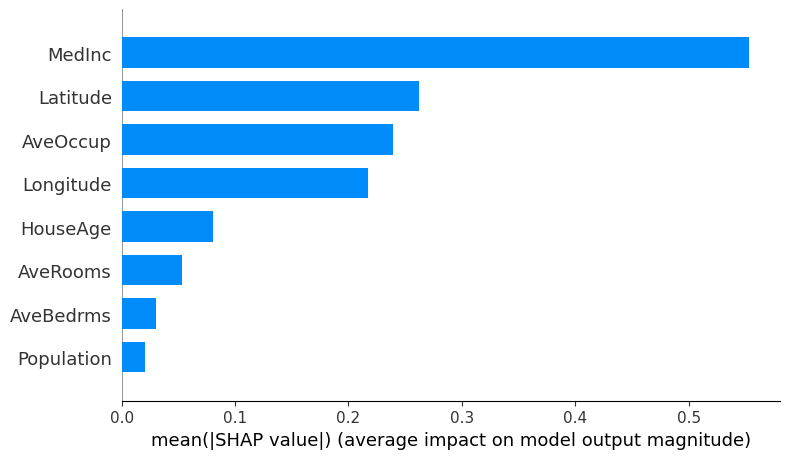

In [22]:
# Summarize the importance of each feature for predictions in the test set
# TODO: Create a shap bar plot that ranks the most important to least important feature
shap.summary_plot(shap_values, X_test, plot_type="bar")

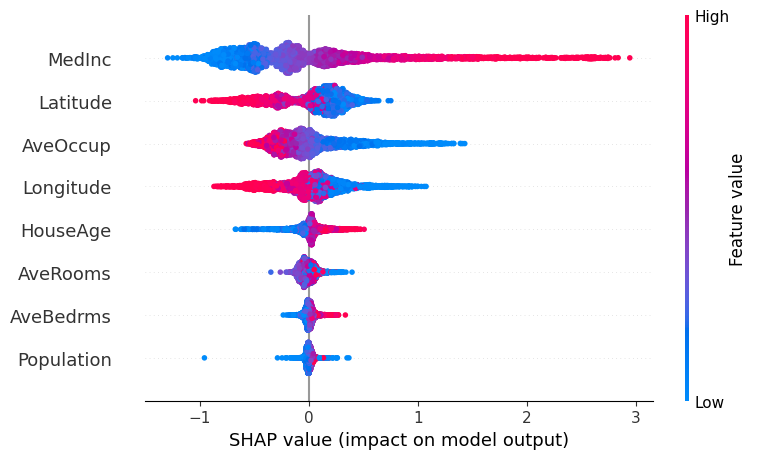

In [15]:
# A more detailed summary plot
# TODO: Create the default SHAP plot (hint: how can you change the previous line of code to create an image
# like the one shown below)
shap.summary_plot(shap_values, X_test)

Features are ranked by importance, with the most impactful at the top.
MedInc (Median Income) is the most important feature, meaning it has the highest impact on house prices.
SHAP Value (X-axis impact on model output)

A positive SHAP value means the feature increases the predicted price.
A negative SHAP value means the feature decreases the predicted price.

In [16]:
# Let's pick one row of data and explain that single prediction
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]

# We create an explainer specifically for that row
shap_explanation = explainer.shap_values(data_for_prediction)

# Force plot for a single observation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_explanation, data_for_prediction)

In this section you:
1) Train a simple model
2) Use shap.TreeExplainer
3) Summarize global feature importance
4) Explain a single prediction with a force plot

Next, let's move on to a more advanced medical imaging example with MONAI and an Attention U-Net.


## Part 2: Attention U-Net with MONAI 3D Segmentation

In this section, we'll show a simplified pipeline to:
1) Download the Medical Segmentation Decathlon Spleen dataset
2) Define transforms, dataset, and dataloader
3) Create an Attention U-Net model
4) Train for a small number of epochs
5) Validate using Dice metric

Because we use an Attention U-Net, we have an "attention gate" mechanism which can help visualize *where* the model is focusing within the data. This is a form of interpretability or explainability in medical image analysis.

For more details, see:
- https://docs.monai.io/en/stable/
- https://monai.io/

In [1]:
!pip install monai==0.9.1 nibabel tqdm -q

!pip install --upgrade "torch==1.11.0" "torchvision==0.12.0" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.7/990.7 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.11.0 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1,

In [1]:
import os
import shutil
import glob
import tempfile
import nibabel as nib
import numpy as np
# TODO: Import necessary libraries for this part
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch

from monai.transforms import (
    LoadImaged,
    AddChanneld,
    CropForegroundd,
    ScaleIntensityRanged,
    SpatialPadd,
    RandSpatialCropd,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    EnsureTyped,
    Compose,
    CenterSpatialCropd
)

from monai.data import CacheDataset, list_data_collate
from monai.networks.nets import AttentionUnet
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.config import print_config
from monai.inferers import sliding_window_inference

print_config()

MONAI version: 0.9.1
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.48.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
import re
import os

# Create a (temporary) directory for data
DATA_ROOT_DIR = os.getcwd()

# The Spleen dataset for the Medical Segmentation Decathlon
MSD_URL = "https://msd-for-monai.s3-us-west-2.amazonaws.com/"
SPLEEN_DATASET_ZIP = "Task09_Spleen.tar"

# Download the dataset if not already present
if not os.path.exists(os.path.join(DATA_ROOT_DIR, "Task09_Spleen")):
    !wget -q {MSD_URL + SPLEEN_DATASET_ZIP} -P {DATA_ROOT_DIR}
    !tar xf {os.path.join(DATA_ROOT_DIR, SPLEEN_DATASET_ZIP)} -C {DATA_ROOT_DIR}
    print("Downloaded and extracted the Task09_Spleen dataset.")
else:
    print("MSD Spleen dataset already exists.")

def get_spleen_index(fname):
    """
    Parse the file name to extract the numeric portion (e.g., 'spleen_10.nii.gz' -> 10).
    """
    base = os.path.basename(fname)
    match = re.search(r"spleen_(\d+)\.nii", base)
    return int(match.group(1)) if match else -1

# Gather all spleen_*.nii.gz in imagesTr and labelsTr
images_dir = os.path.join(DATA_ROOT_DIR, "Task09_Spleen/imagesTr")
labels_dir = os.path.join(DATA_ROOT_DIR, "Task09_Spleen/labelsTr")

image_files = sorted(glob.glob(os.path.join(images_dir, "spleen_*.nii.gz")), key=get_spleen_index)
label_files = sorted(glob.glob(os.path.join(labels_dir, "spleen_*.nii.gz")), key=get_spleen_index)

# Decide how many for training, how many for validation
training_images = image_files[:30]
training_labels = label_files[:30]
validation_images = image_files[30:]
validation_labels = label_files[30:]

# Build the data dictionary - very important to format correctly
train_data = [
    {"image": img, "label": lbl}
    for img, lbl in zip(training_images, training_labels)
]

val_data = [
    {"image": img, "label": lbl}
    for img, lbl in zip(validation_images, validation_labels)
]

print("Number of training files:", len(train_data))
print("Number of validation files:", len(val_data))

MSD Spleen dataset already exists.
Number of training files: 30
Number of validation files: 11


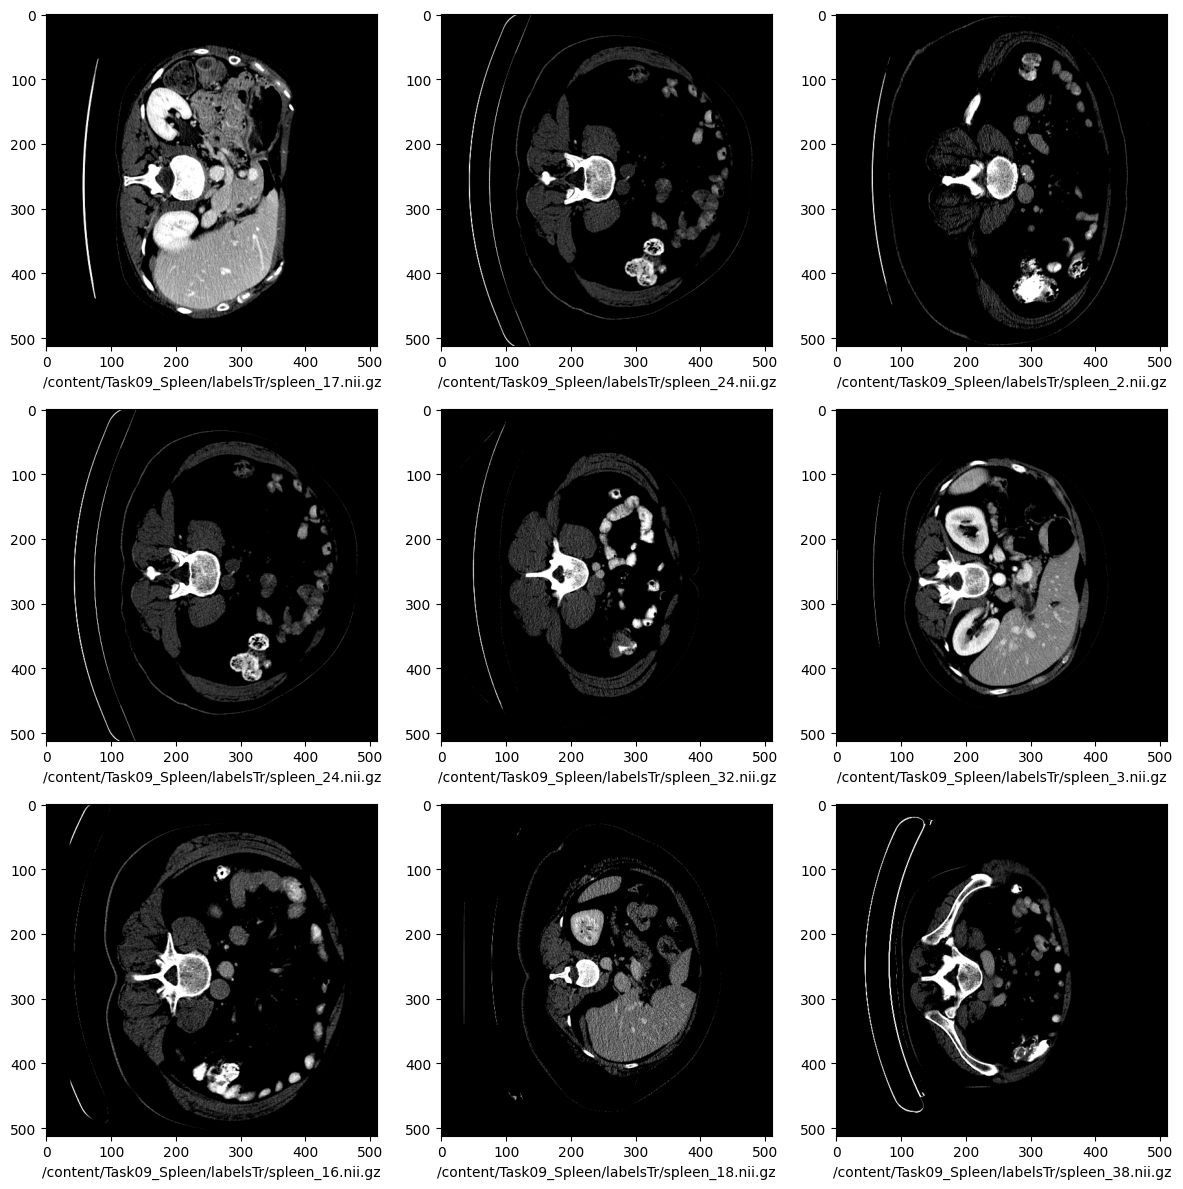

In [3]:
import PIL
import matplotlib.pyplot as plt

plt.subplots(3, 3, figsize=(12, 12))
for i, k in enumerate(np.random.randint(len(train_data), size=9)):
  data_item = train_data[k]
  img = nib.load(data_item["image"])
  img_data = img.get_fdata()

  # Select the middle slice along the last axis (depth)
  middle_slice = img_data[:, :, img_data.shape[2] // 2]

  plt.subplot(3, 3, i + 1)
  plt.xlabel(data_item["label"])
  plt.imshow(middle_slice, cmap="gray", vmin=0, vmax=255)

plt.tight_layout()
plt.show()

In [4]:
sample_image_path = train_data[0]["image"]
sample_image = nib.load(sample_image_path)
print(f"Original image shape: {sample_image.shape}")

# Find minimum dimension across all training images
min_dim = float('inf')
for data_item in train_data:
    img = nib.load(data_item["image"])
    shape = img.shape
    current_min = min(shape)
    if current_min < min_dim:
        min_dim = current_min
        min_shape = shape

print(f"Smallest dimension found: {min_dim}")
print(f"Shape with smallest dimension: {min_shape}")

Original image shape: (512, 512, 90)
Smallest dimension found: 31
Shape with smallest dimension: (512, 512, 31)


In [5]:
min_a, max_a = [], []

for data_item in train_data:
    img = nib.load(data_item["image"])  # Load NIfTI file
    img_data = img.get_fdata()  # Convert to NumPy array

    # Compute percentiles to determine a_min and a_max
    a_min = np.percentile(img_data, 1)  # 1st percentile
    a_max = np.percentile(img_data, 99) # 99th percentile

    min_a.append(a_min)
    max_a.append(a_max)

# Compute global minimum and maximum
min_a = np.max(min_a)
max_a = np.min(max_a)

print(f"Recommended a_min: {min_a}, a_max: {max_a}")

Recommended a_min: -1024.0, a_max: 178.0


In [6]:
# Use a reasonable crop size based on the minimum dimension
crop_size = 32
print(f"Using crop size: {crop_size}")

# TODO: Define the training/validation transformations using MONAI's Compose function.
# Hint: Include transformations such as LoadImaged, AddChanneld, CropForegroundd, and ScaleIntensityRanged.

keys = ["image", "label"]

# Define train transforms with simpler approach
train_transforms = Compose([
    # Load the image and label data
    LoadImaged(keys=keys),
    # Add channel dimensions
    AddChanneld(keys=keys),
    # Crop foreground using the image as reference
    CropForegroundd(
        keys=keys,
        source_key="image"
    ),
    # Scale intensity range for normalization
    ScaleIntensityRanged(
        keys=keys,
        a_min=min_a,
        a_max=max_a,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    # Pad first to ensure minimum size
    SpatialPadd(
        keys=keys,
        spatial_size=[crop_size, crop_size, crop_size]
    ),
    # Then use simple random crop instead of RandCropByPosNegLabeld
    RandSpatialCropd(
        keys=keys,
        roi_size=[crop_size, crop_size, crop_size],
        random_size=False
    ),
    EnsureTyped(keys=keys),
])

# Define validation transforms with same approach
val_transforms = Compose([
    # Similar to train_transforms
    # Load the image and label data
    LoadImaged(keys=keys),
    # Add channel dimensions
    AddChanneld(keys=keys),
    # Crop foreground using the image as reference
    CropForegroundd(
        keys=keys,
        source_key="image"
    ),
    # Scale intensity range for normalization,
    ScaleIntensityRanged(
        keys=keys,
        a_min=min_a,
        a_max=max_a,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    # Pad first to ensure minimum size
    SpatialPadd(
        keys=keys,
        spatial_size=[crop_size, crop_size, crop_size]
    ),
    # Use center crop for validation
    CenterSpatialCropd(
        keys=keys,
        roi_size=[crop_size, crop_size, crop_size]
    ),
    EnsureTyped(keys=keys),
])

Using crop size: 32


In [7]:
# Create datasets with the transforms
train_ds = CacheDataset(
    data=train_data,
    transform=train_transforms,
    cache_rate=1.0
)

val_ds = CacheDataset(
    data=val_data,
    transform=val_transforms,
    cache_rate=1.0
)

# Create data loaders
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=list_data_collate,
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=list_data_collate,
)

print("Train loader length:", len(train_loader))
print("Validation loader length:", len(val_loader))

Loading dataset: 100%|██████████| 11/11 [00:21<00:00,  1.95s/it]

Train loader length: 15
Validation loader length: 11


In [14]:
# Safely check a single item from the dataset
try:
    print("Attempting to access first training dataset item:")
    item = train_ds[0]
    print(f"Keys in item: {list(item.keys())}")
    print(f"Image shape: {item['image'].shape}")
    print(f"Label shape: {item['label'].shape}")

    print("\nChecking first batch from train_loader:")
    batch = next(iter(train_loader))
    print(f"Batch keys: {list(batch.keys())}")
    print(f"Batch image shape: {batch['image'].shape}")
    print(f"Batch label shape: {batch['label'].shape}")
except Exception as e:
    print(f"Error accessing dataset: {e}")

Attempting to access first training dataset item:
Keys in item: ['image', 'label', 'image_meta_dict', 'label_meta_dict', 'foreground_start_coord', 'foreground_end_coord']
Image shape: (1, 32, 32, 32)
Label shape: (1, 32, 32, 32)

Checking first batch from train_loader:
Batch keys: ['image', 'label', 'image_meta_dict', 'label_meta_dict', 'foreground_start_coord', 'foreground_end_coord']
Batch image shape: (2, 1, 32, 32, 32)
Batch label shape: (2, 1, 32, 32, 32)


In [21]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create the Attention UNet model
# TODO: Define and initialize the Attention U-Net model
model = AttentionUnet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,  # Background + spleen
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
).to(device)

# Define loss function, optimizer, and metric
# TODO: Define the loss function, optimizer, and evaluation metric.
# Hint:
# - Use DiceLoss for segmentation loss (convert labels to one-hot and apply softmax).
# - Use Adam optimizer with a small learning rate (e.g., 1e-4).
# - Use DiceMetric to evaluate segmentation performance, ignoring the background.

loss_function = DiceLoss(to_onehot_y=True, softmax=True) # Define loss function
optimizer = torch.optim.Adam(model.parameters(), 1e-4)  # Initialize the optimizer
dice_metric = DiceMetric(include_background=False)  # Define the metric for evaluation

Using device: cuda


In [22]:
# Set consistent ROI size for both training and inference
roi_size = [crop_size, crop_size, crop_size]

# Training parameters
max_epochs = 10
val_interval = 1

# Training loop
try:
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader):
            step += 1
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= step
        print(f"Average Training Loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)

                    # Use consistent ROI size for inference
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size=roi_size, sw_batch_size=1, predictor=model
                    )

                    # Calculate Dice metric
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # Calculate mean Dice score
                mean_dice_val = dice_metric.aggregate().item()
                dice_metric.reset()

                print(f"Validation Mean Dice: {mean_dice_val:.4f}")
except Exception as e:
    import traceback
    print(f"Error during training: {e}")
    traceback.print_exc()

Epoch 1/10


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:219: UserWarning: y_pred should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:219: UserWarning: y should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")


Average Training Loss: 0.6792
Validation Mean Dice: 0.4621
Epoch 2/10


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


Average Training Loss: 0.6518
Validation Mean Dice: 0.4512
Epoch 3/10


100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


Average Training Loss: 0.6439
Validation Mean Dice: 0.4247
Epoch 4/10


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Average Training Loss: 0.6395
Validation Mean Dice: 0.4175
Epoch 5/10


100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


Average Training Loss: 0.6364
Validation Mean Dice: 0.4071
Epoch 6/10


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


Average Training Loss: 0.6339
Validation Mean Dice: 0.3999
Epoch 7/10


100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Average Training Loss: 0.6306
Validation Mean Dice: 0.3852
Epoch 8/10


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


Average Training Loss: 0.6284
Validation Mean Dice: 0.3660
Epoch 9/10


100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


Average Training Loss: 0.6266
Validation Mean Dice: 0.3527
Epoch 10/10


100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Average Training Loss: 0.6243
Validation Mean Dice: 0.3457


Added hook to: model.1.attention
Added hook to: model.1.attention.W_g
Added hook to: model.1.attention.W_g.0
Added hook to: model.1.attention.W_g.0.conv
Added hook to: model.1.attention.W_g.1
Added hook to: model.1.attention.W_x
Added hook to: model.1.attention.W_x.0
Added hook to: model.1.attention.W_x.0.conv
Added hook to: model.1.attention.W_x.1
Added hook to: model.1.attention.psi
Added hook to: model.1.attention.psi.0
Added hook to: model.1.attention.psi.0.conv
Added hook to: model.1.attention.psi.1
Added hook to: model.1.attention.psi.2
Added hook to: model.1.attention.relu
Added hook to: model.1.submodule.1.attention
Added hook to: model.1.submodule.1.attention.W_g
Added hook to: model.1.submodule.1.attention.W_g.0
Added hook to: model.1.submodule.1.attention.W_g.0.conv
Added hook to: model.1.submodule.1.attention.W_g.1
Added hook to: model.1.submodule.1.attention.W_x
Added hook to: model.1.submodule.1.attention.W_x.0
Added hook to: model.1.submodule.1.attention.W_x.0.conv
Added

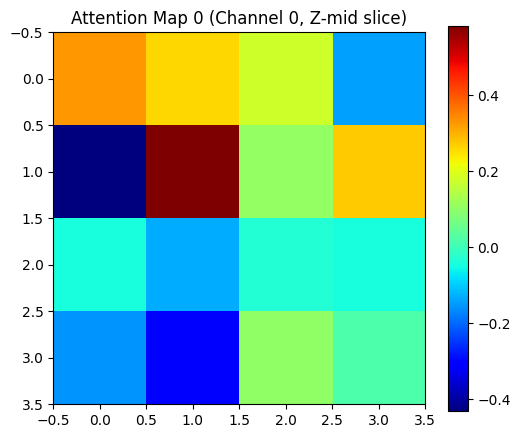

Attention map 1 shape: (1, 64, 4, 4, 4)


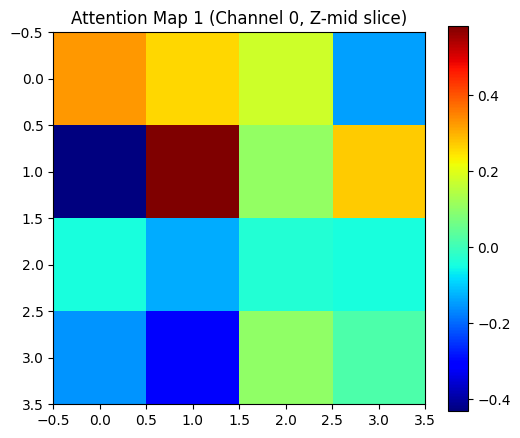

Attention map 2 shape: (1, 64, 4, 4, 4)


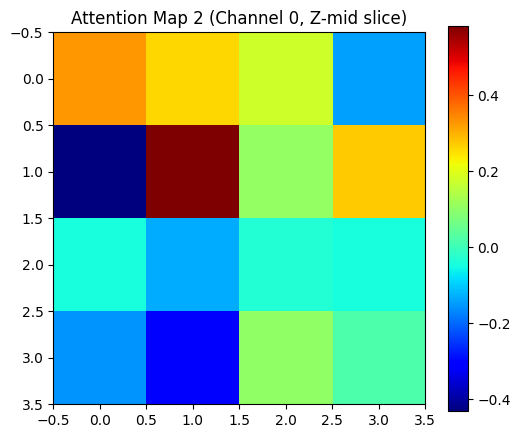

Attention map 3 shape: (1, 64, 4, 4, 4)


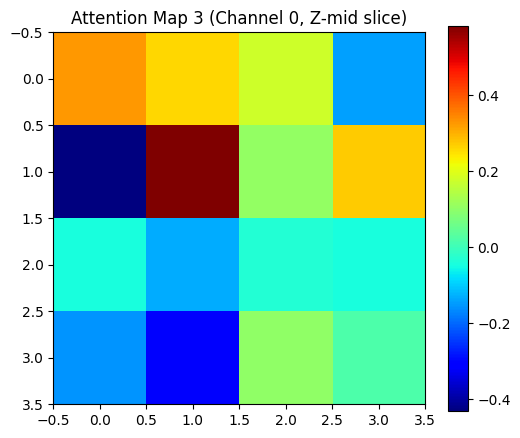

Attention map 4 shape: (1, 64, 4, 4, 4)


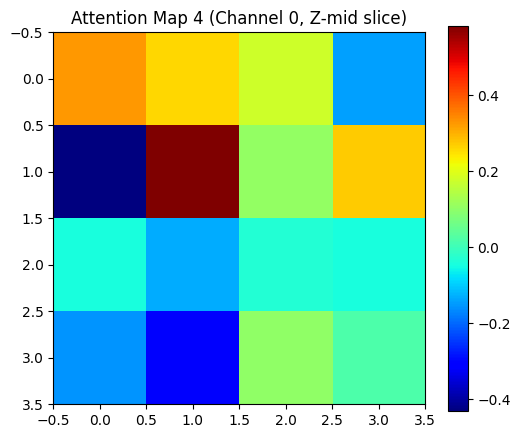

Attention map 5 shape: (1, 64, 4, 4, 4)


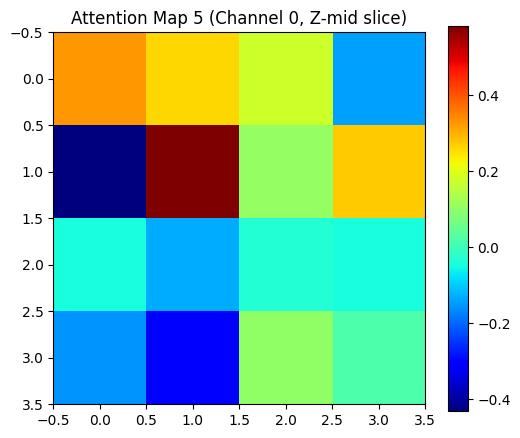

Attention map 6 shape: (1, 64, 4, 4, 4)


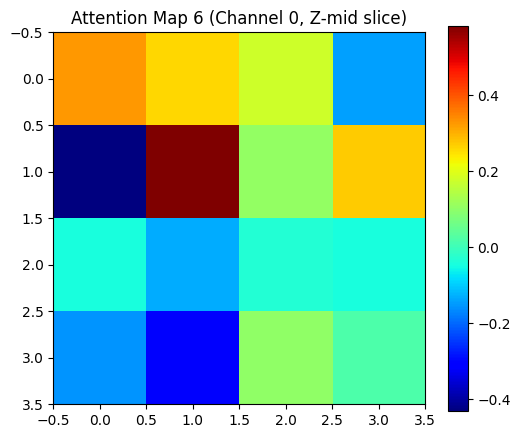

Attention map 7 shape: (1, 64, 4, 4, 4)


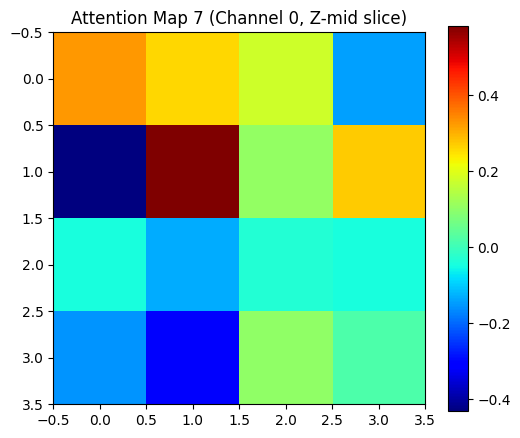

Attention map 8 shape: (1, 64, 4, 4, 4)


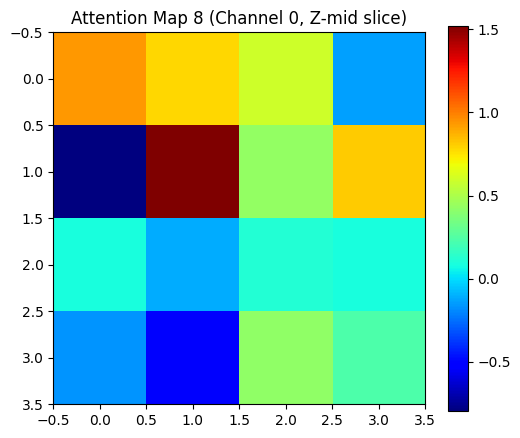

Attention map 9 shape: (1, 64, 4, 4, 4)


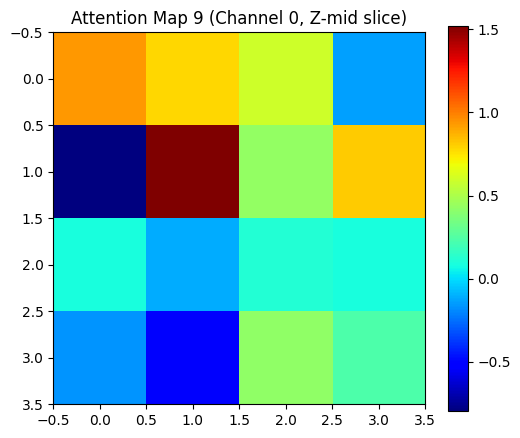

Attention map 10 shape: (1, 64, 4, 4, 4)


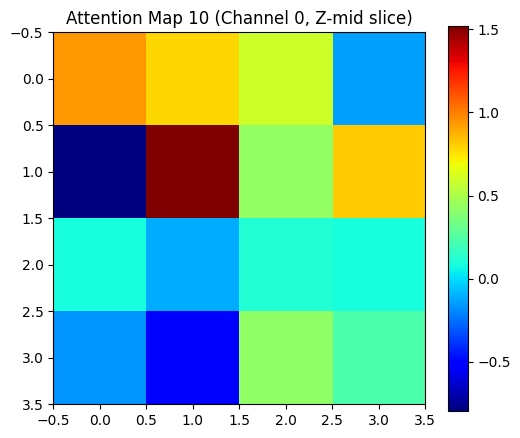

Attention map 11 shape: (1, 64, 4, 4, 4)


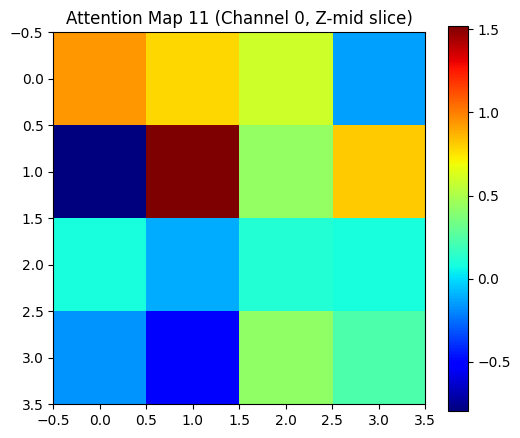

Attention map 12 shape: (1, 64, 4, 4, 4)


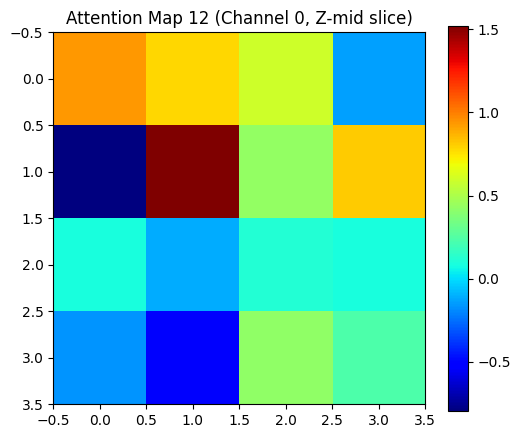

Attention map 13 shape: (1, 64, 4, 4, 4)


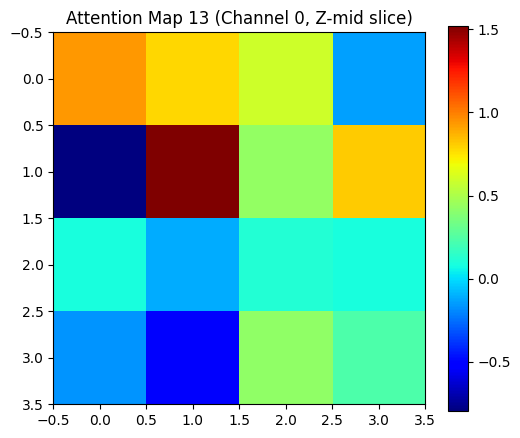

Attention map 14 shape: (1, 64, 4, 4, 4)


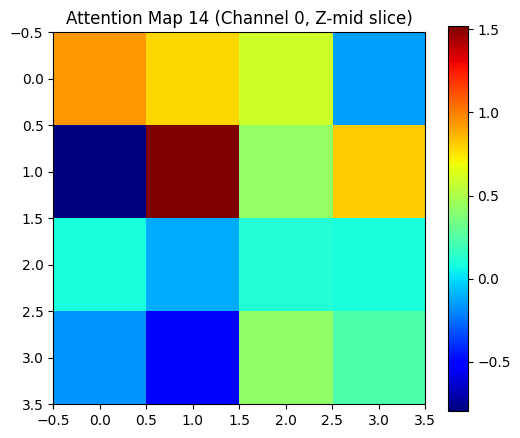

Attention map 15 shape: (1, 64, 4, 4, 4)


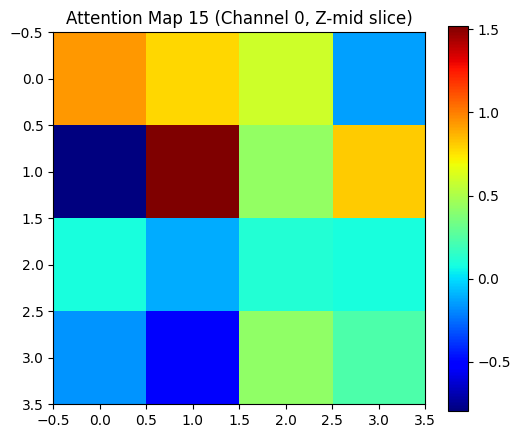

Attention map 16 shape: (1, 64, 4, 4, 4)


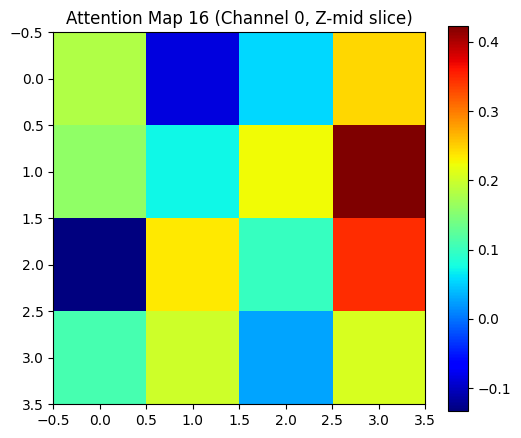

Attention map 17 shape: (1, 64, 4, 4, 4)


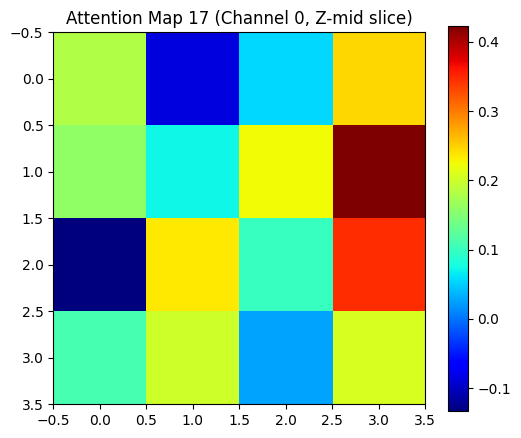

Attention map 18 shape: (1, 64, 4, 4, 4)


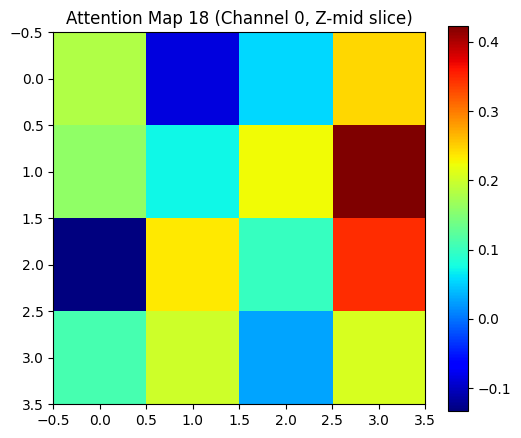

Attention map 19 shape: (1, 64, 4, 4, 4)


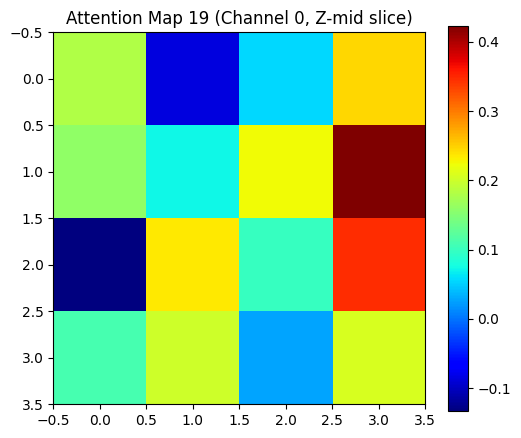

Attention map 20 shape: (1, 64, 4, 4, 4)


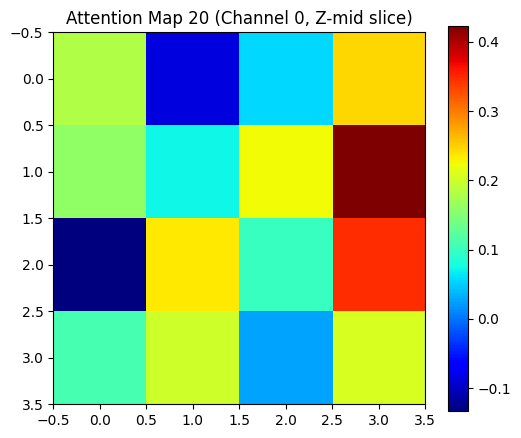

Attention map 21 shape: (1, 64, 4, 4, 4)


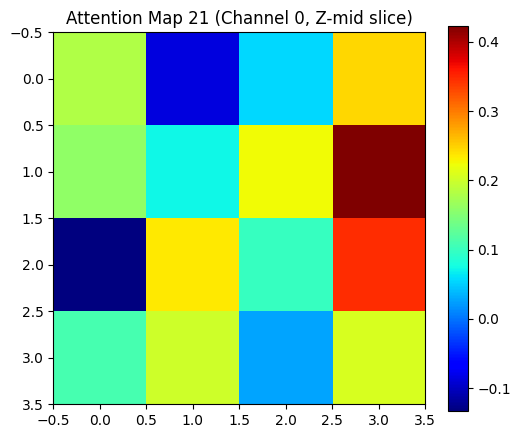

Attention map 22 shape: (1, 64, 4, 4, 4)


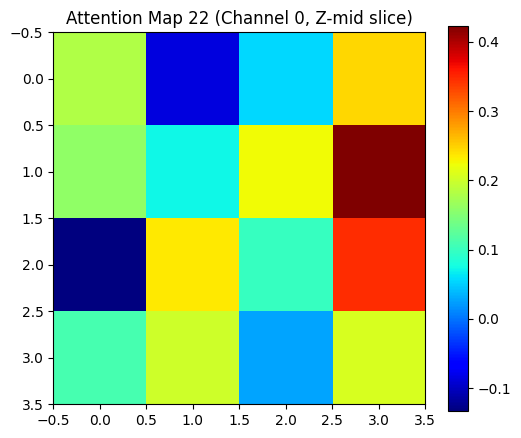

Attention map 23 shape: (1, 64, 4, 4, 4)


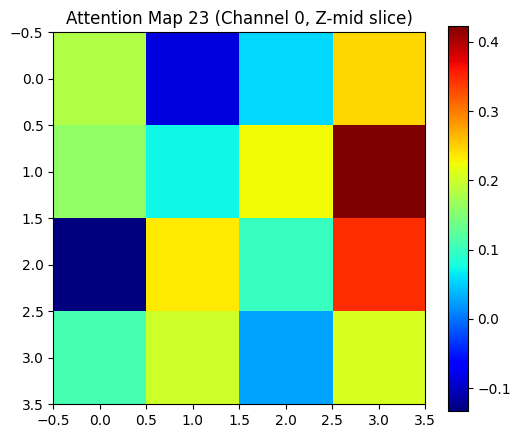

Attention map 24 shape: (1, 64, 4, 4, 4)


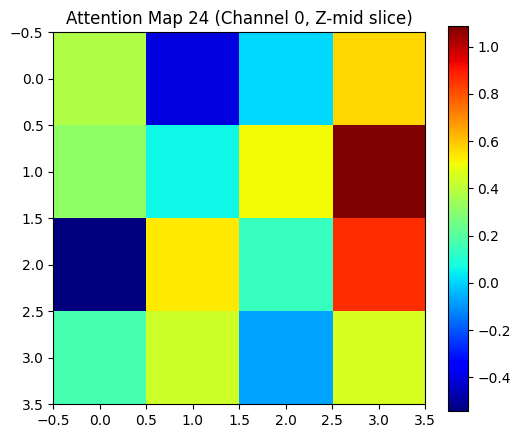

Attention map 25 shape: (1, 64, 4, 4, 4)


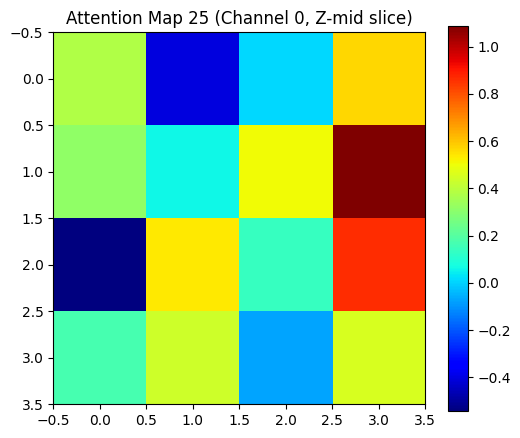

Attention map 26 shape: (1, 64, 4, 4, 4)


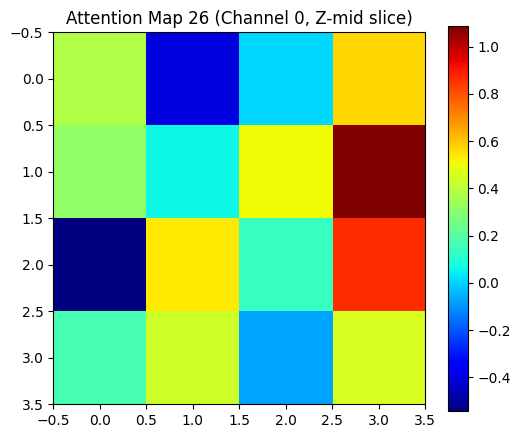

Attention map 27 shape: (1, 64, 4, 4, 4)


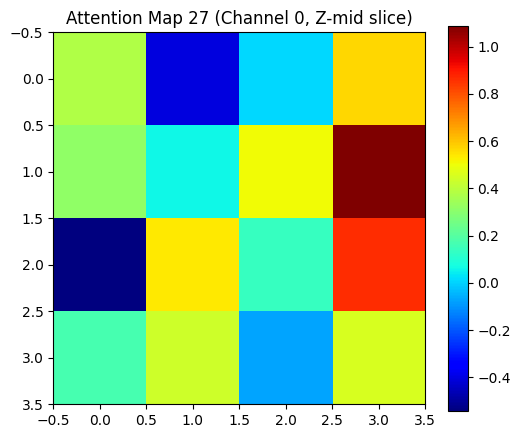

Attention map 28 shape: (1, 64, 4, 4, 4)


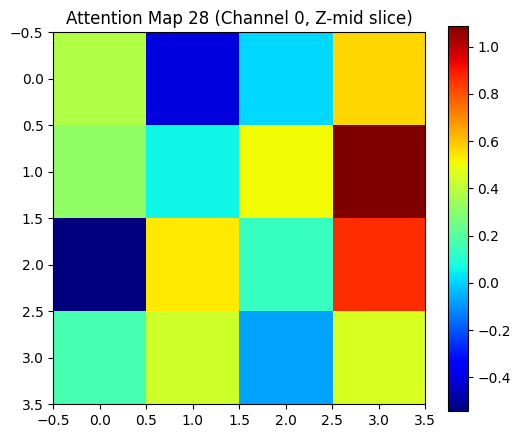

Attention map 29 shape: (1, 64, 4, 4, 4)


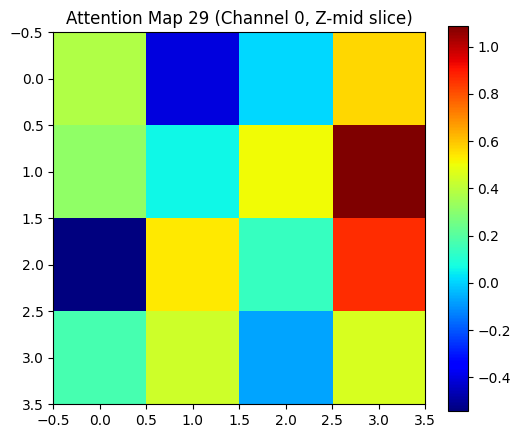

Attention map 30 shape: (1, 64, 4, 4, 4)


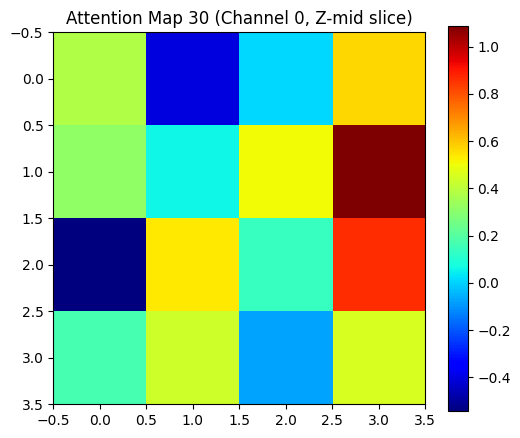

Attention map 31 shape: (1, 64, 4, 4, 4)


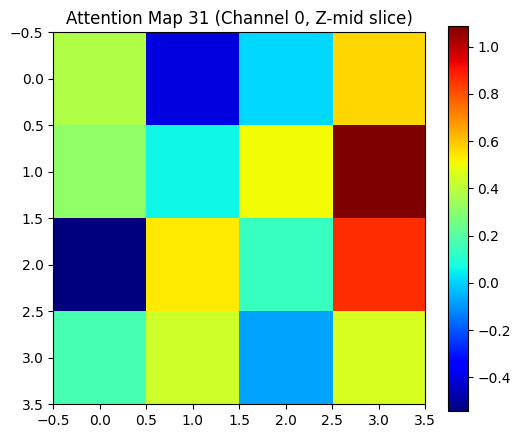

Attention map 32 shape: (1, 64, 4, 4, 4)


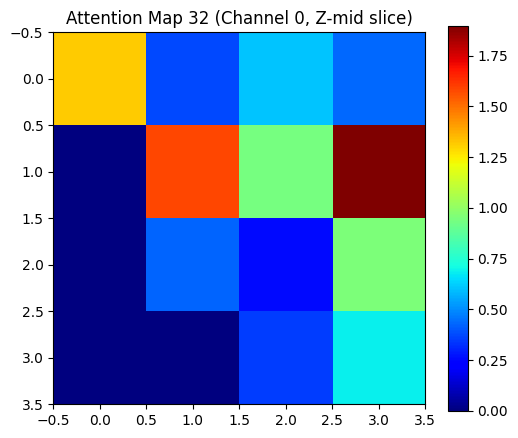

Attention map 33 shape: (1, 64, 4, 4, 4)


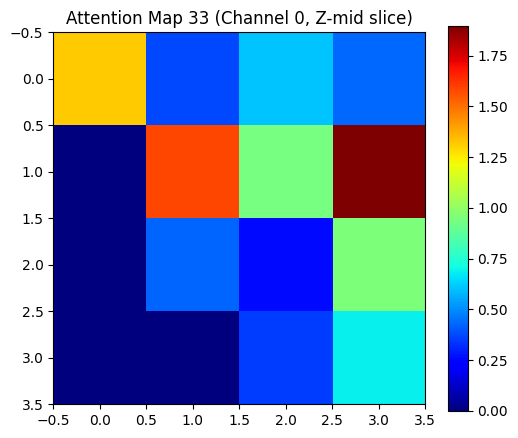

Attention map 34 shape: (1, 64, 4, 4, 4)


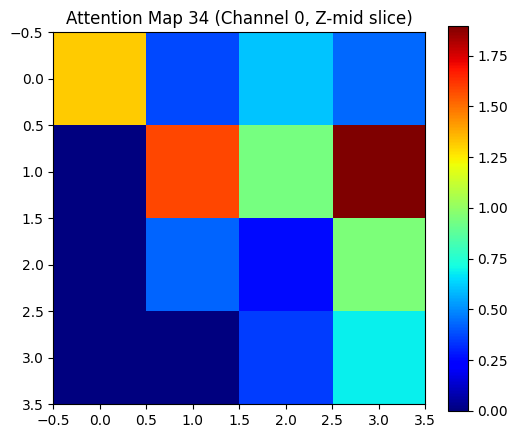

Attention map 35 shape: (1, 64, 4, 4, 4)


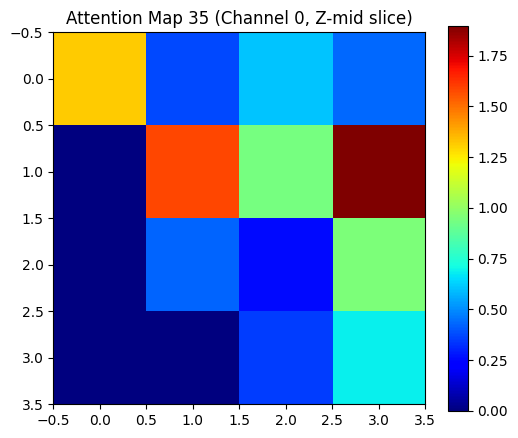

Attention map 36 shape: (1, 1, 4, 4, 4)


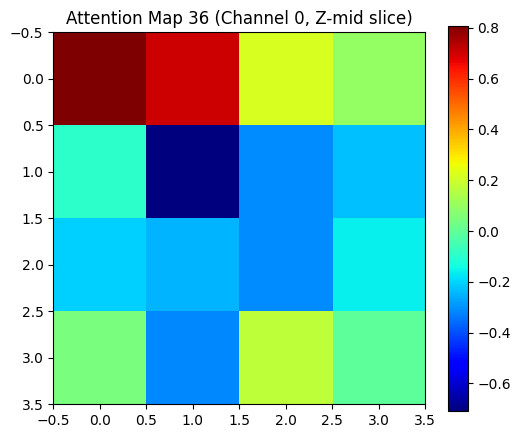

Attention map 37 shape: (1, 1, 4, 4, 4)


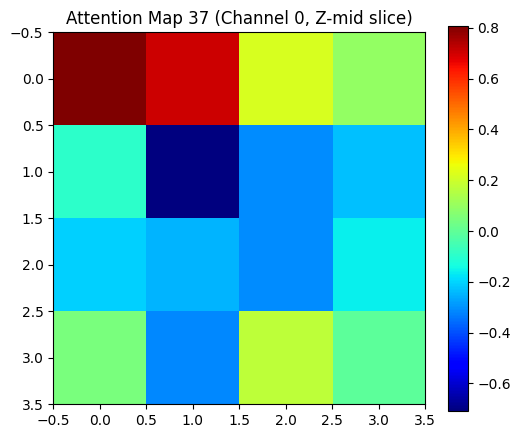

Attention map 38 shape: (1, 1, 4, 4, 4)


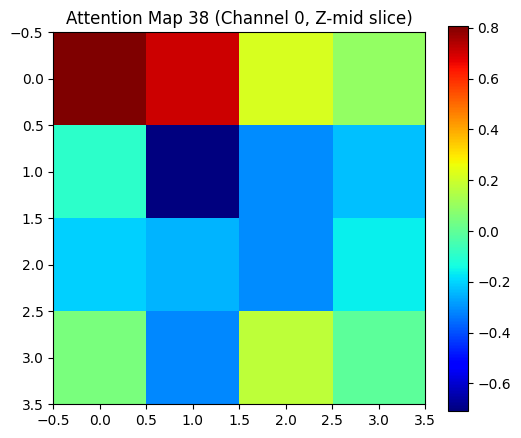

Attention map 39 shape: (1, 1, 4, 4, 4)


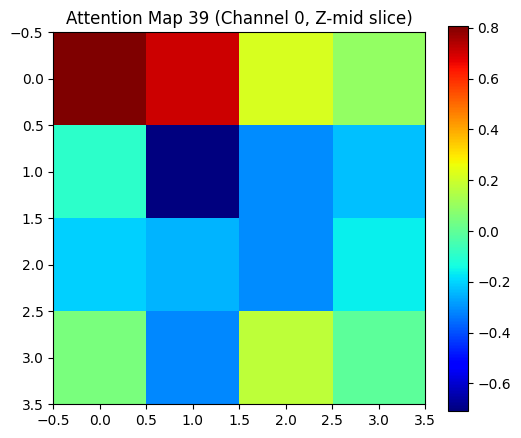

Attention map 40 shape: (1, 1, 4, 4, 4)


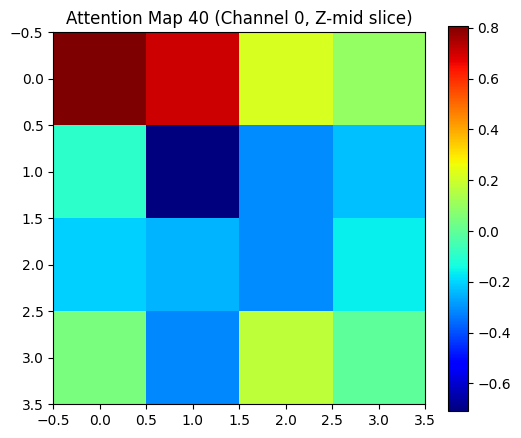

Attention map 41 shape: (1, 1, 4, 4, 4)


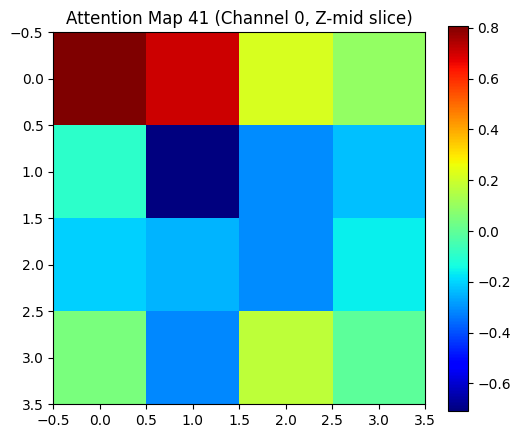

Attention map 42 shape: (1, 1, 4, 4, 4)


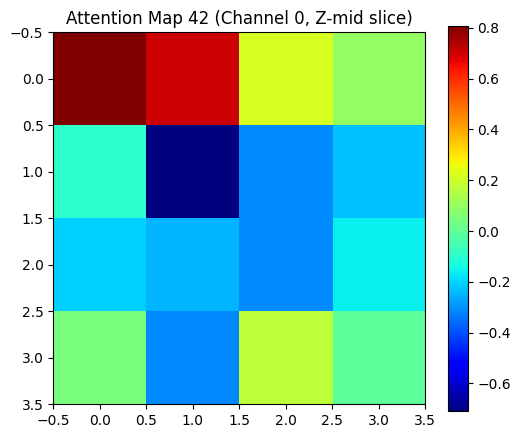

Attention map 43 shape: (1, 1, 4, 4, 4)


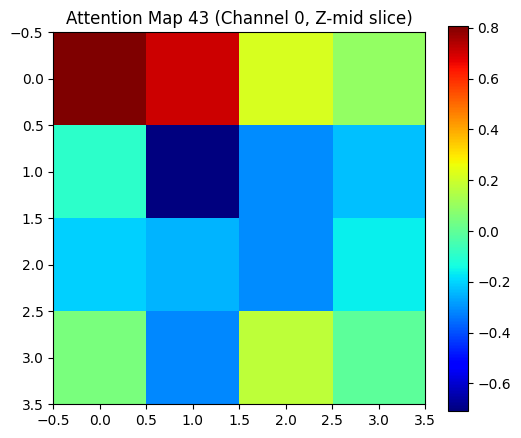

Attention map 44 shape: (1, 1, 4, 4, 4)


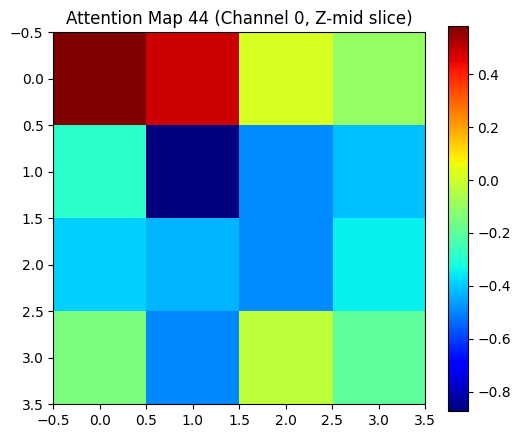

Attention map 45 shape: (1, 1, 4, 4, 4)


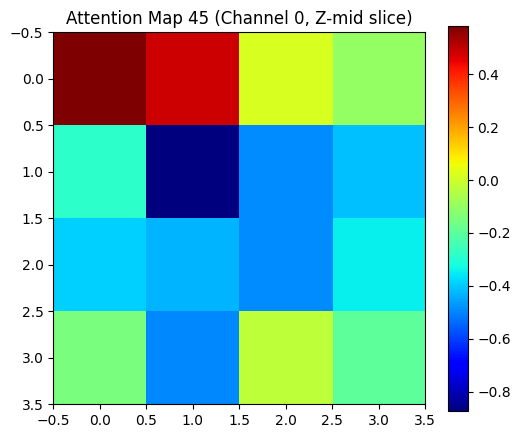

Attention map 46 shape: (1, 1, 4, 4, 4)


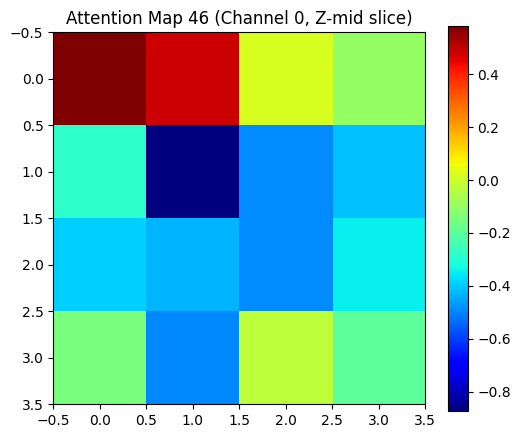

Attention map 47 shape: (1, 1, 4, 4, 4)


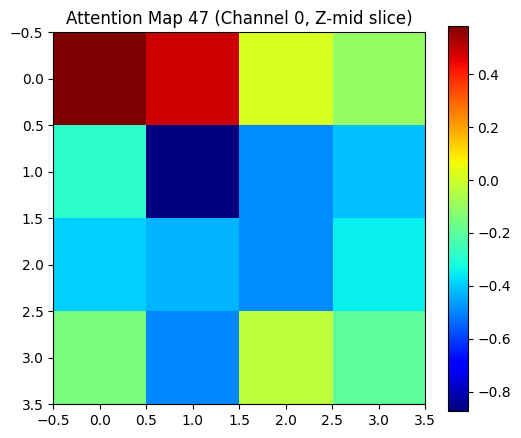

Attention map 48 shape: (1, 1, 4, 4, 4)


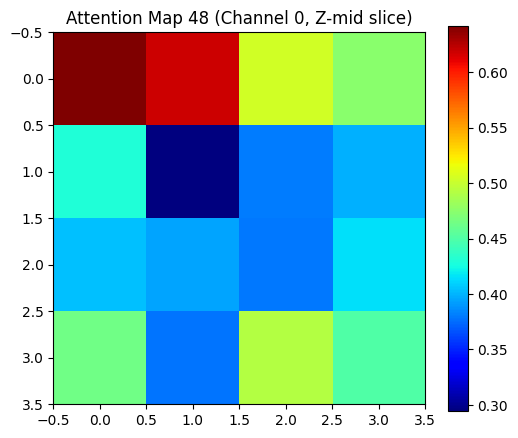

Attention map 49 shape: (1, 1, 4, 4, 4)


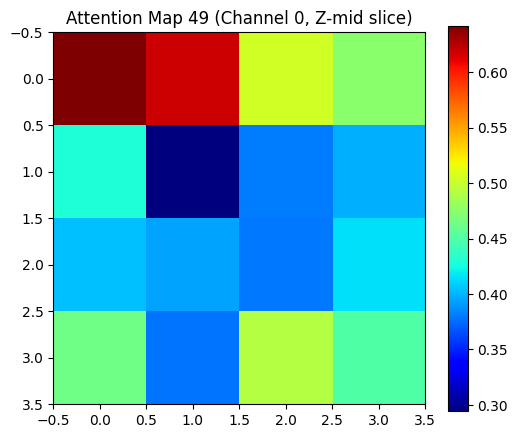

Attention map 50 shape: (1, 1, 4, 4, 4)


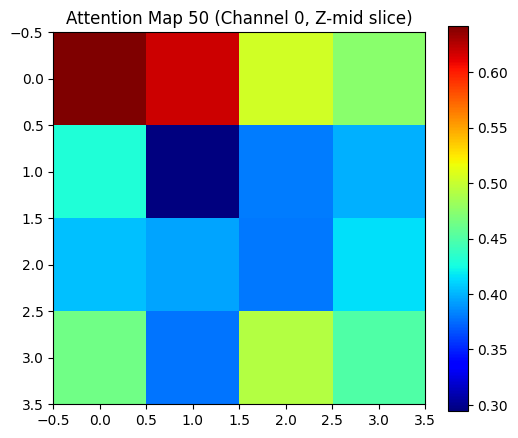

Attention map 51 shape: (1, 1, 4, 4, 4)


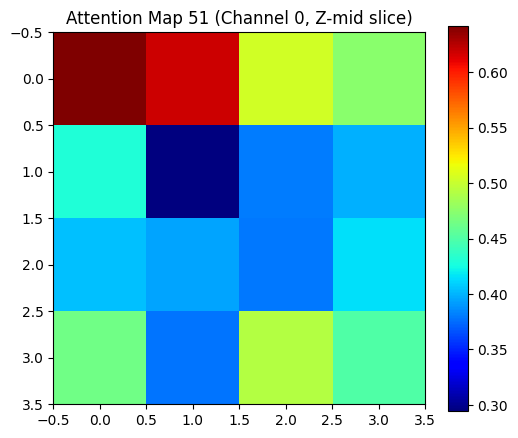

Attention map 52 shape: (1, 1, 4, 4, 4)


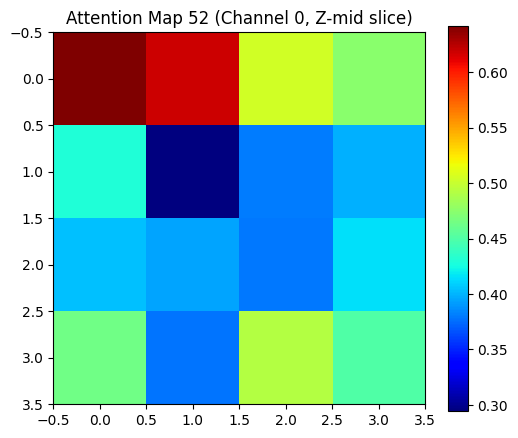

Attention map 53 shape: (1, 1, 4, 4, 4)


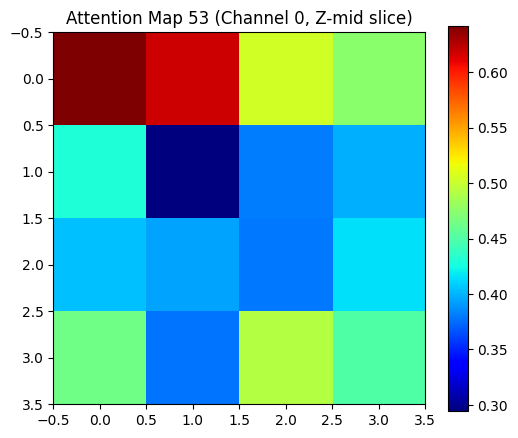

Attention map 54 shape: (1, 1, 4, 4, 4)


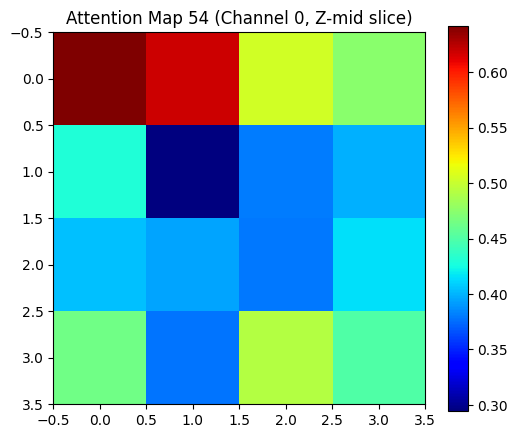

Attention map 55 shape: (1, 1, 4, 4, 4)


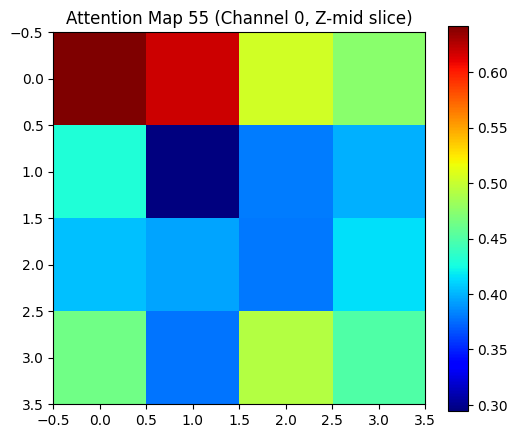

Attention map 56 shape: (1, 128, 4, 4, 4)


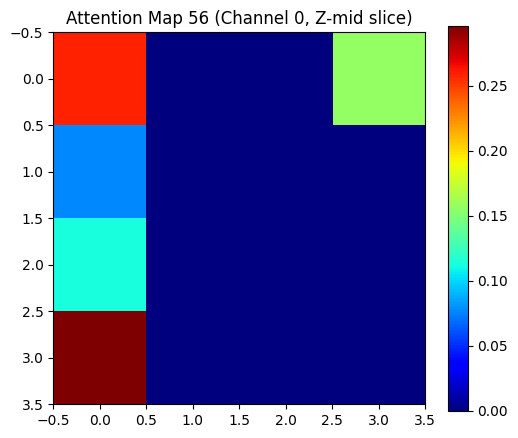

Attention map 57 shape: (1, 128, 4, 4, 4)


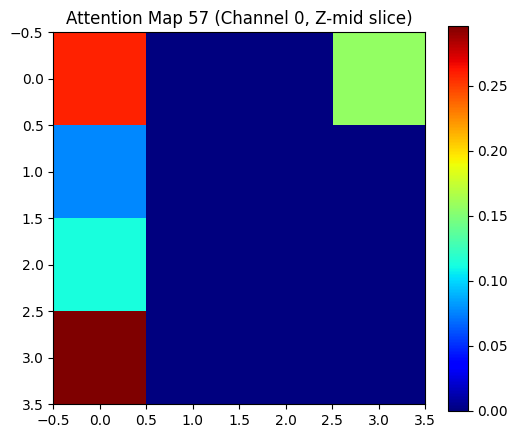

Attention map 58 shape: (1, 128, 4, 4, 4)


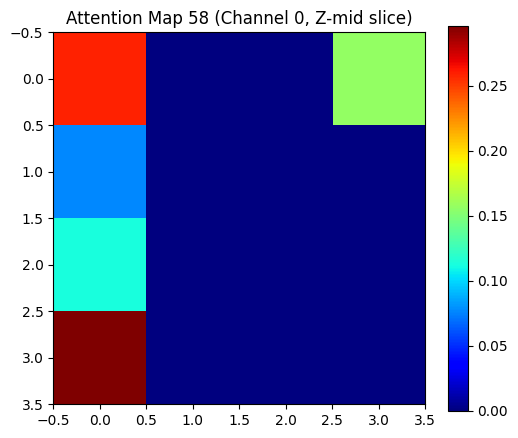

Attention map 59 shape: (1, 128, 4, 4, 4)


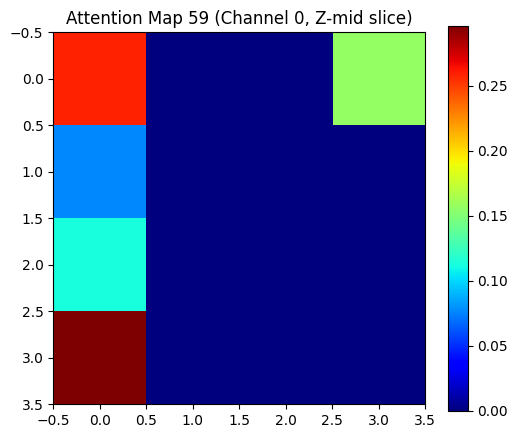

Attention map 60 shape: (1, 32, 8, 8, 8)


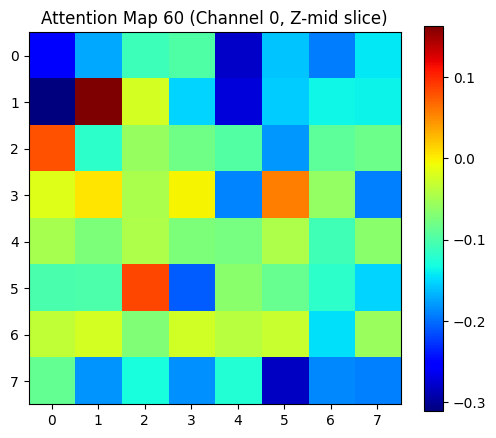

Attention map 61 shape: (1, 32, 8, 8, 8)


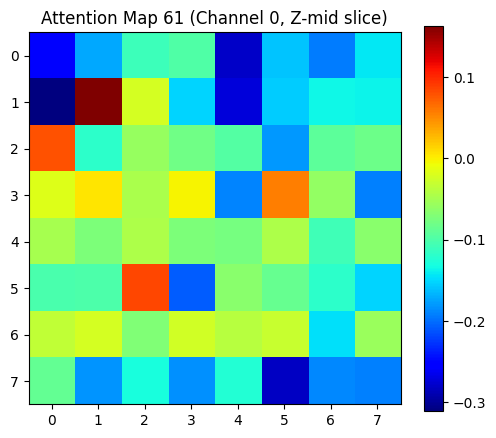

Attention map 62 shape: (1, 32, 8, 8, 8)


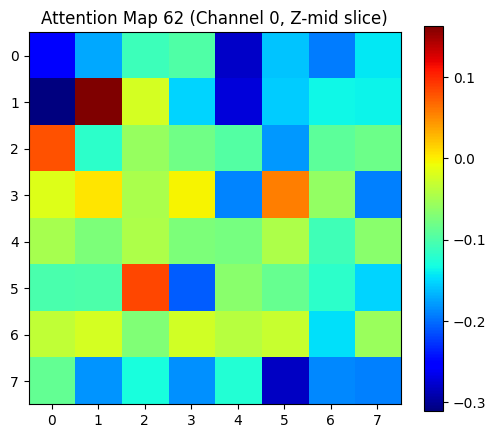

Attention map 63 shape: (1, 32, 8, 8, 8)


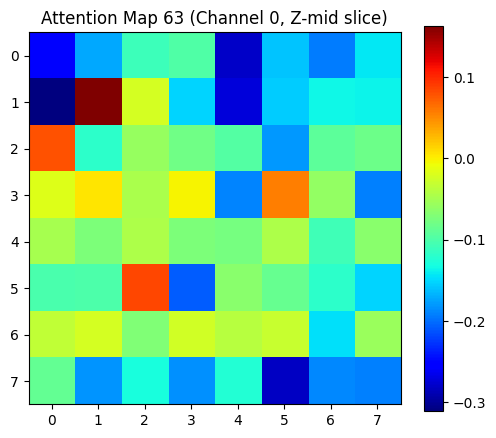

Attention map 64 shape: (1, 32, 8, 8, 8)


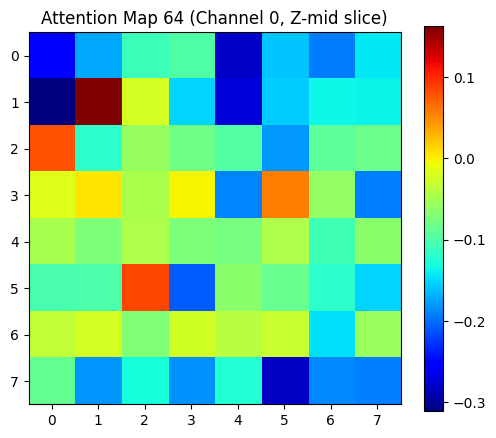

Attention map 65 shape: (1, 32, 8, 8, 8)


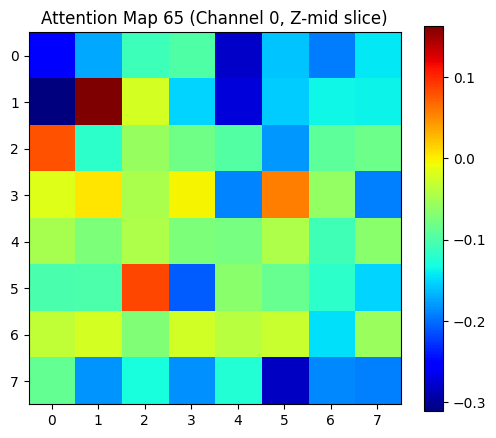

Attention map 66 shape: (1, 32, 8, 8, 8)


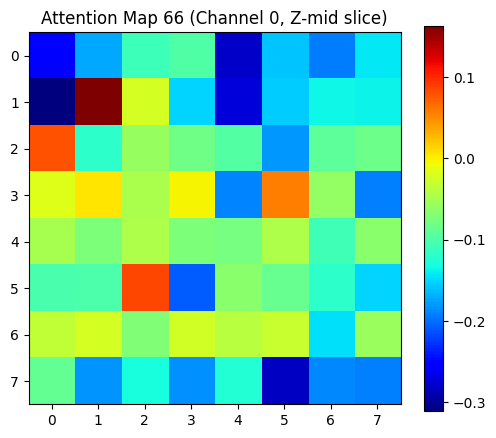

Attention map 67 shape: (1, 32, 8, 8, 8)


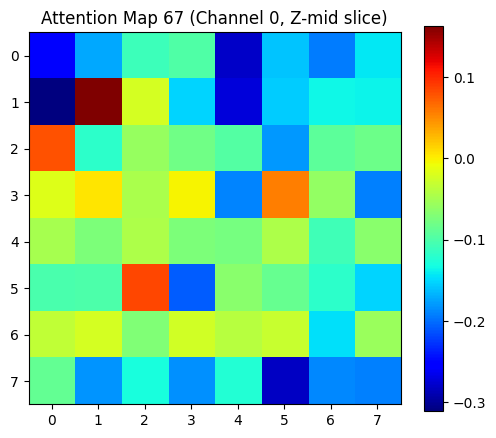

Attention map 68 shape: (1, 32, 8, 8, 8)


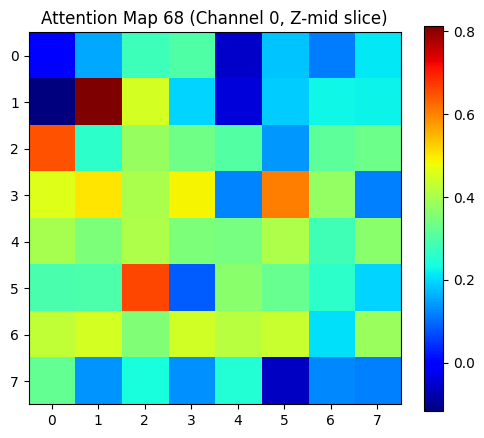

Attention map 69 shape: (1, 32, 8, 8, 8)


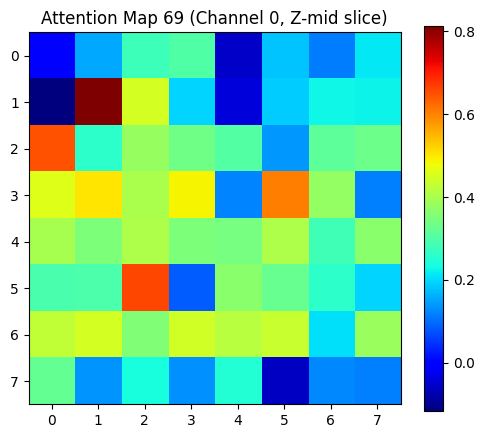

Attention map 70 shape: (1, 32, 8, 8, 8)


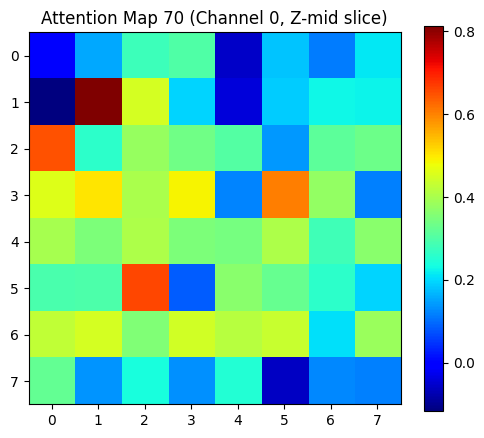

Attention map 71 shape: (1, 32, 8, 8, 8)


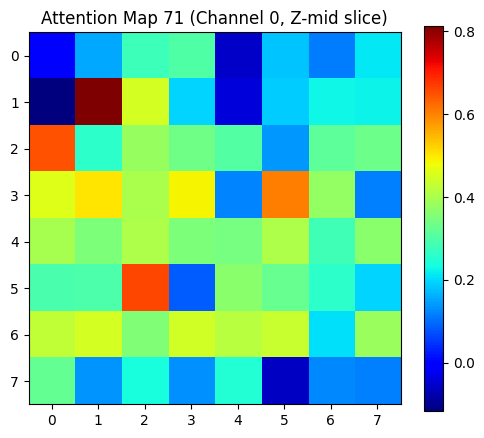

Attention map 72 shape: (1, 32, 8, 8, 8)


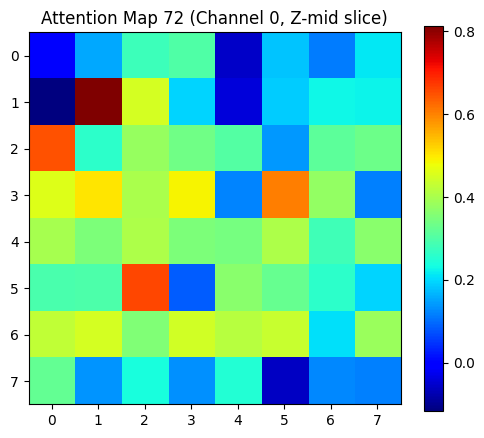

Attention map 73 shape: (1, 32, 8, 8, 8)


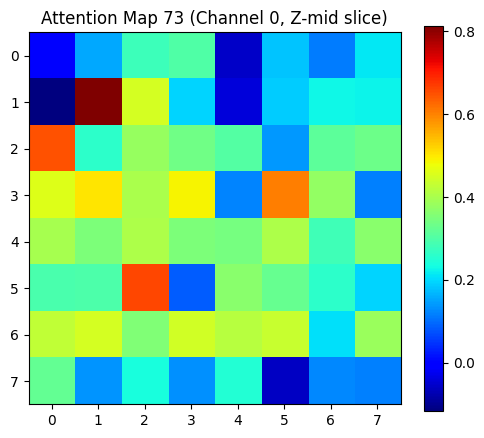

Attention map 74 shape: (1, 32, 8, 8, 8)


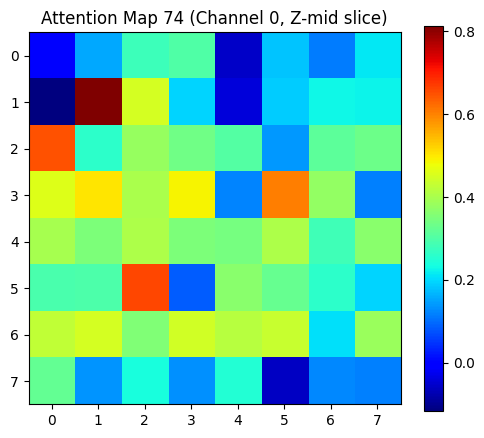

Attention map 75 shape: (1, 32, 8, 8, 8)


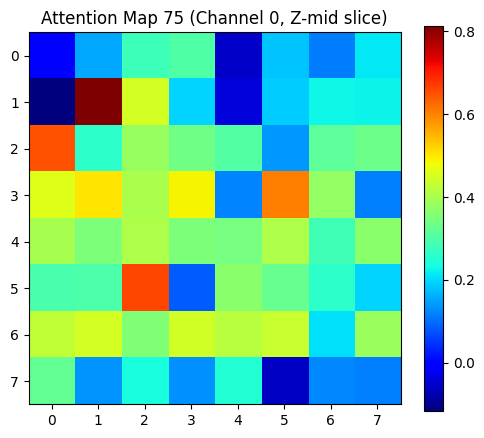

Attention map 76 shape: (1, 32, 8, 8, 8)


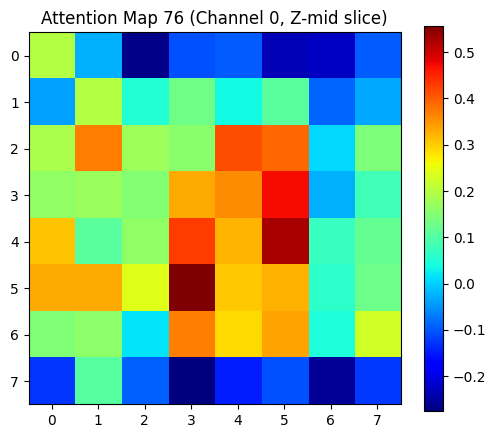

Attention map 77 shape: (1, 32, 8, 8, 8)


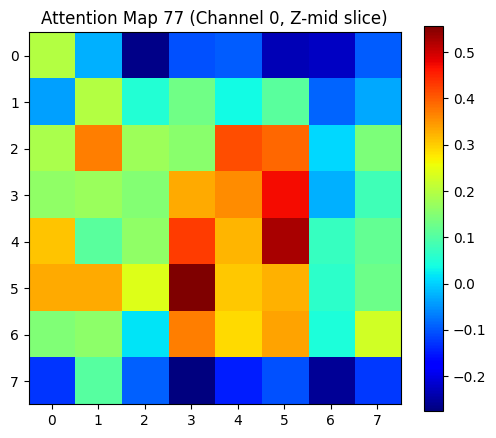

Attention map 78 shape: (1, 32, 8, 8, 8)


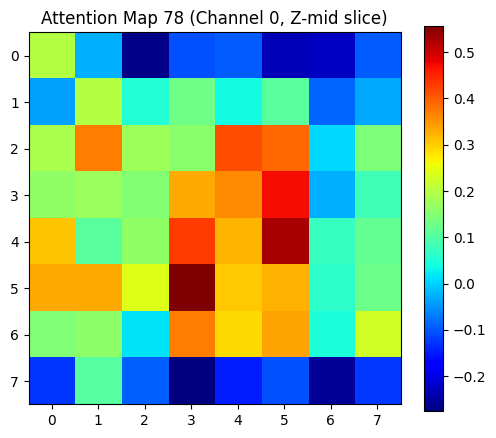

Attention map 79 shape: (1, 32, 8, 8, 8)


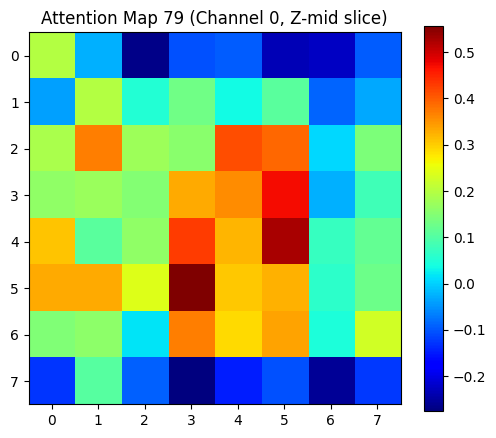

Attention map 80 shape: (1, 32, 8, 8, 8)


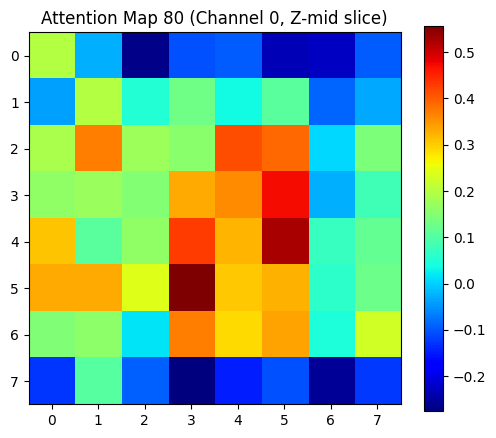

Attention map 81 shape: (1, 32, 8, 8, 8)


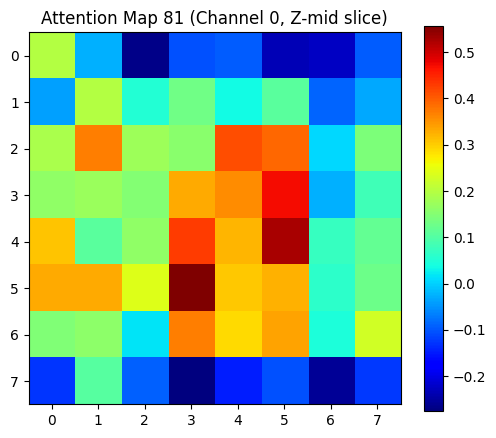

Attention map 82 shape: (1, 32, 8, 8, 8)


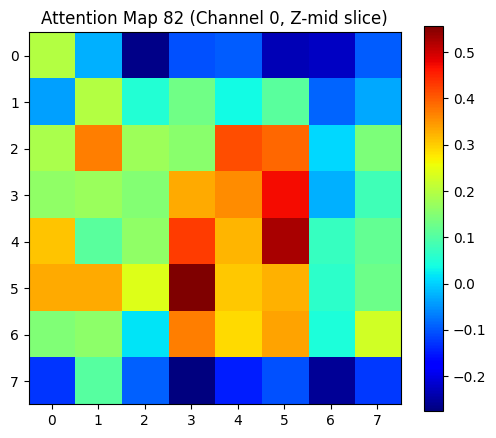

Attention map 83 shape: (1, 32, 8, 8, 8)


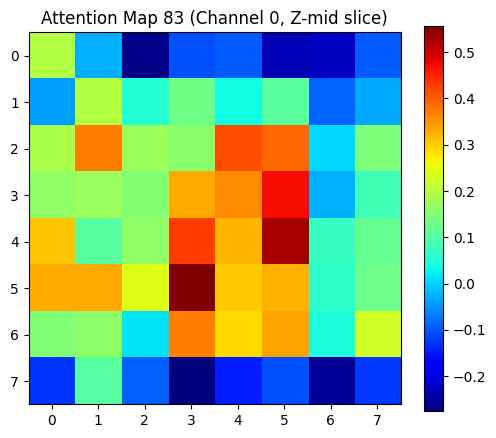

Attention map 84 shape: (1, 32, 8, 8, 8)


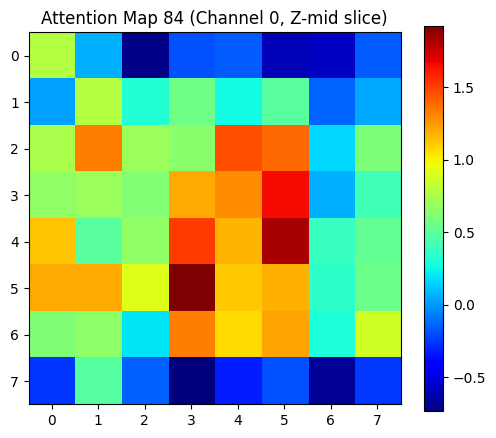

Attention map 85 shape: (1, 32, 8, 8, 8)


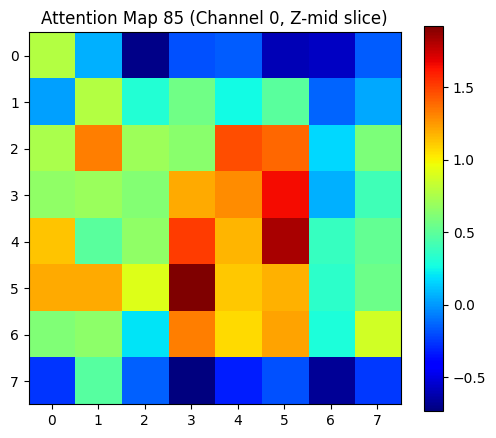

Attention map 86 shape: (1, 32, 8, 8, 8)


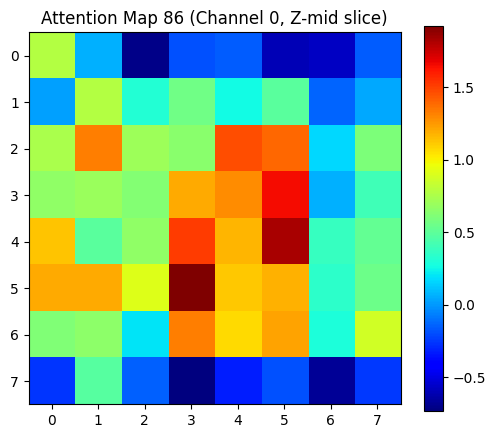

Attention map 87 shape: (1, 32, 8, 8, 8)


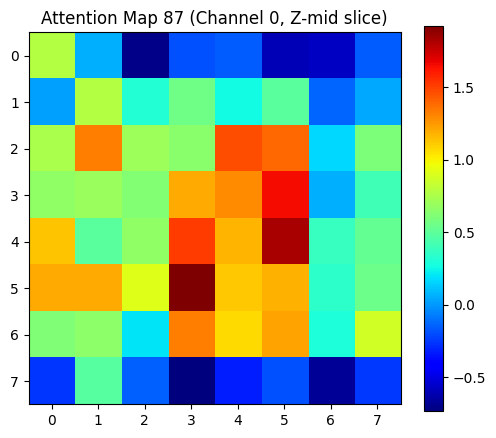

Attention map 88 shape: (1, 32, 8, 8, 8)


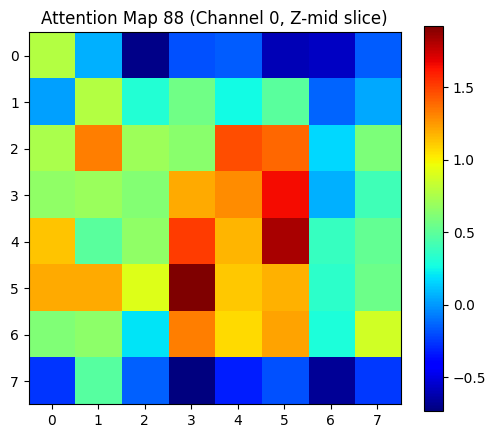

Attention map 89 shape: (1, 32, 8, 8, 8)


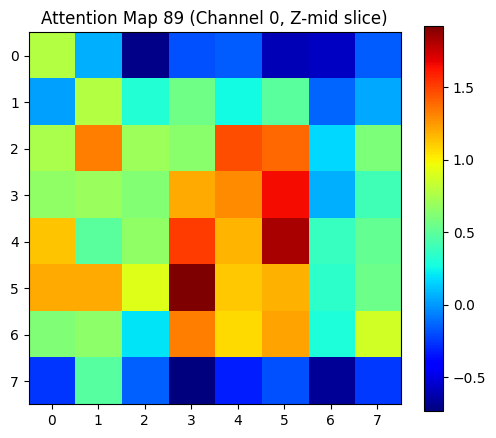

Attention map 90 shape: (1, 32, 8, 8, 8)


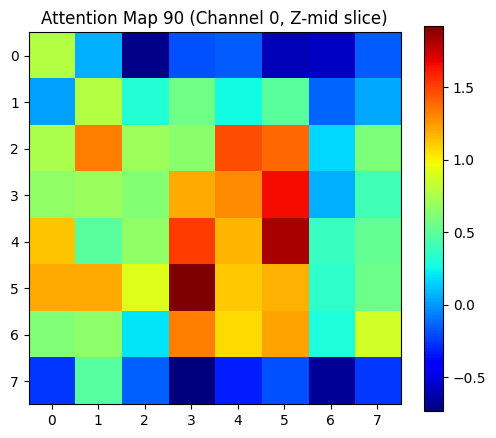

Attention map 91 shape: (1, 32, 8, 8, 8)


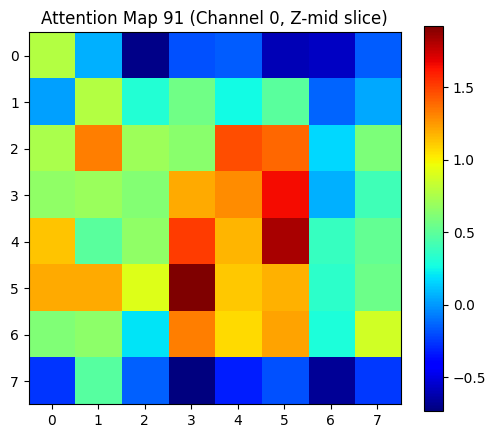

Attention map 92 shape: (1, 32, 8, 8, 8)


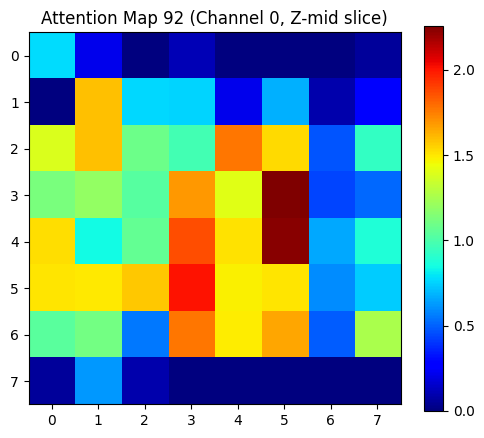

Attention map 93 shape: (1, 32, 8, 8, 8)


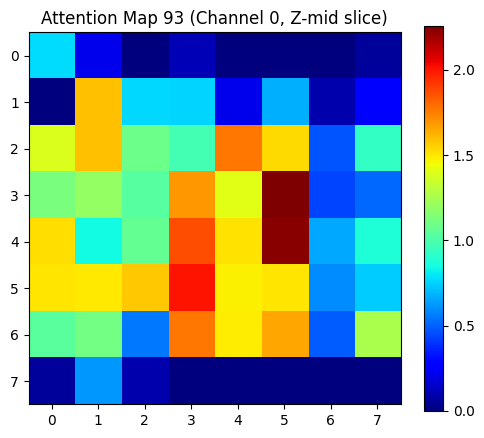

Attention map 94 shape: (1, 32, 8, 8, 8)


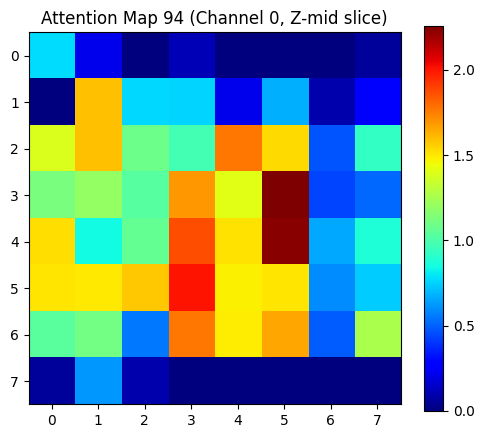

Attention map 95 shape: (1, 32, 8, 8, 8)


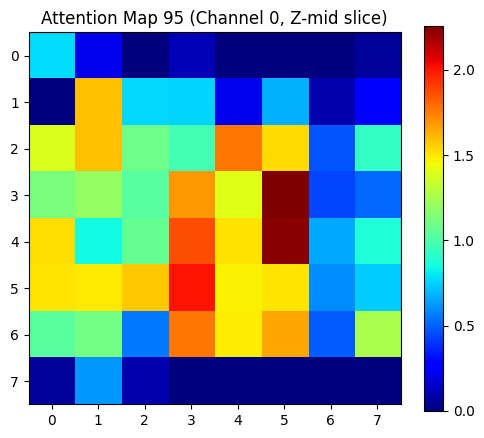

Attention map 96 shape: (1, 1, 8, 8, 8)


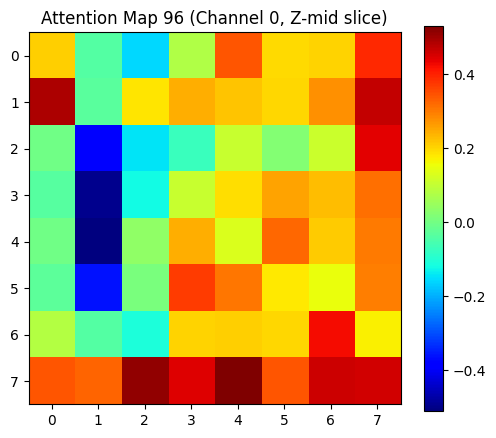

Attention map 97 shape: (1, 1, 8, 8, 8)


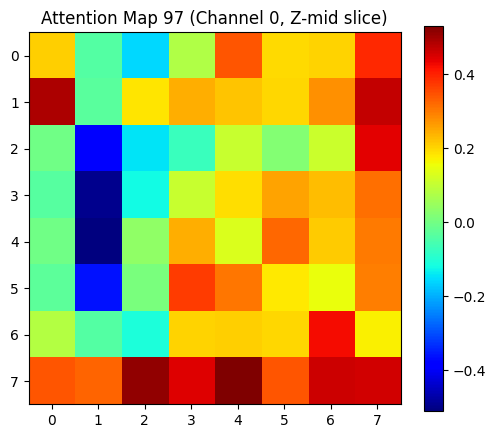

Attention map 98 shape: (1, 1, 8, 8, 8)


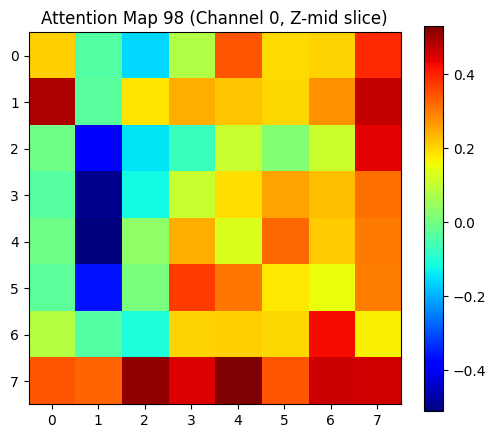

Attention map 99 shape: (1, 1, 8, 8, 8)


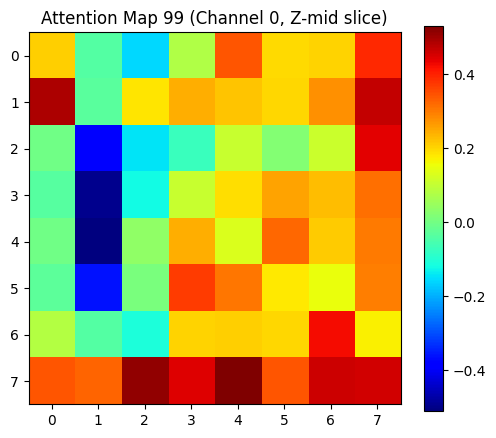

Attention map 100 shape: (1, 1, 8, 8, 8)


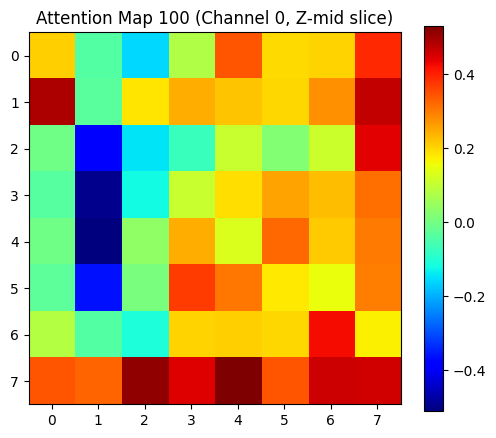

Attention map 101 shape: (1, 1, 8, 8, 8)


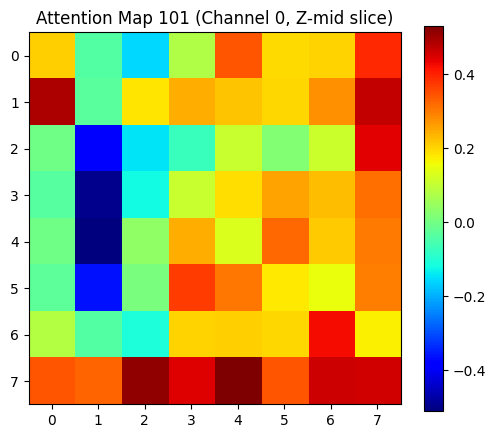

Attention map 102 shape: (1, 1, 8, 8, 8)


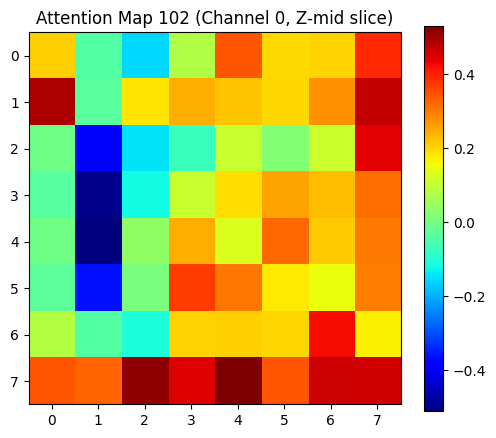

Attention map 103 shape: (1, 1, 8, 8, 8)


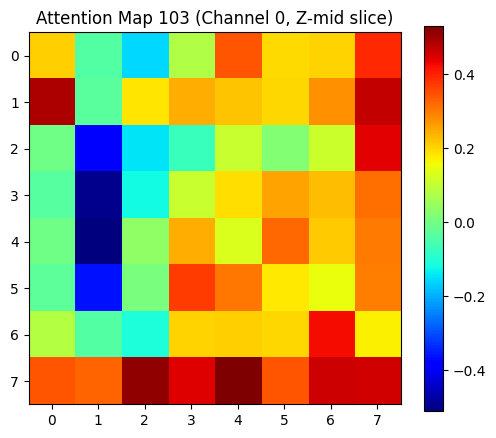

Attention map 104 shape: (1, 1, 8, 8, 8)


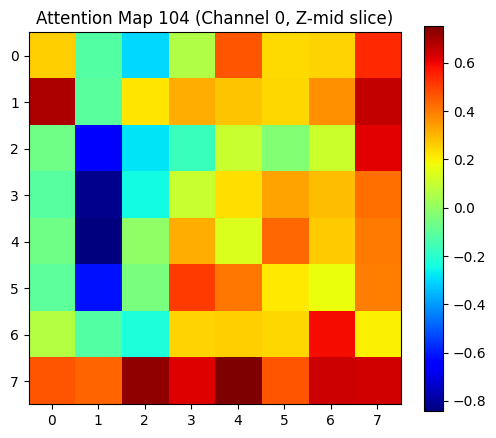

Attention map 105 shape: (1, 1, 8, 8, 8)


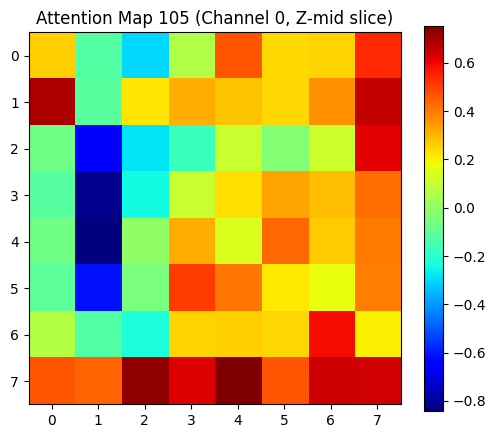

Attention map 106 shape: (1, 1, 8, 8, 8)


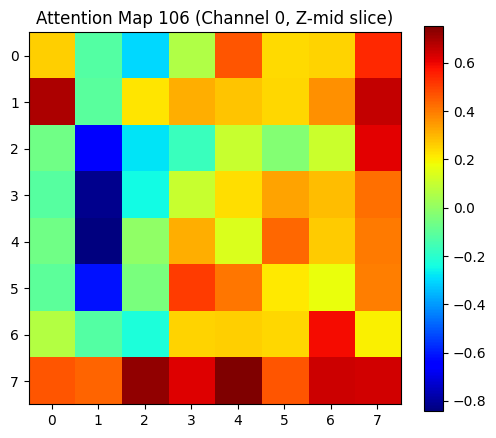

Attention map 107 shape: (1, 1, 8, 8, 8)


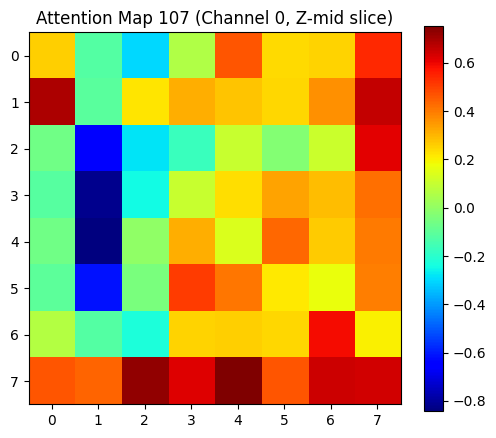

Attention map 108 shape: (1, 1, 8, 8, 8)


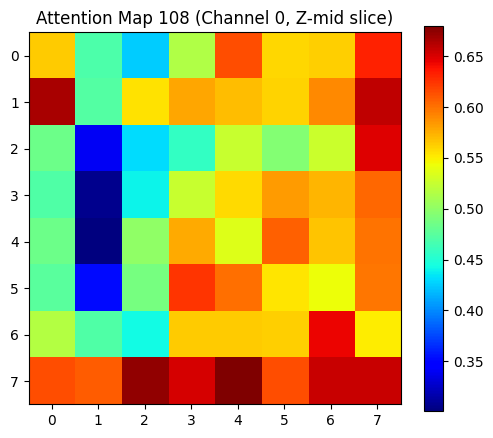

Attention map 109 shape: (1, 1, 8, 8, 8)


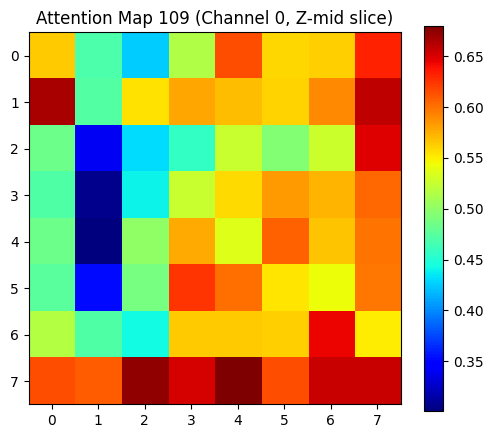

Attention map 110 shape: (1, 1, 8, 8, 8)


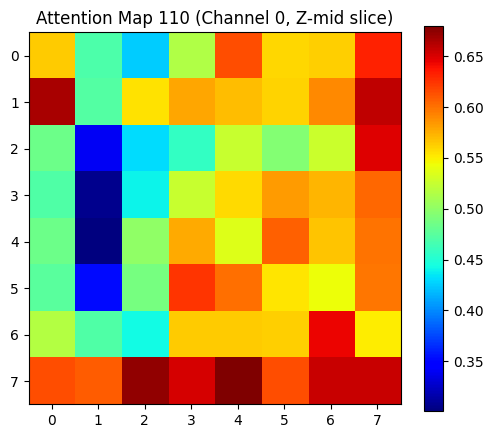

Attention map 111 shape: (1, 1, 8, 8, 8)


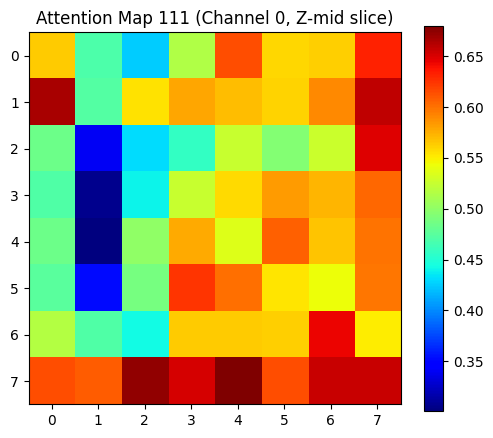

Attention map 112 shape: (1, 1, 8, 8, 8)


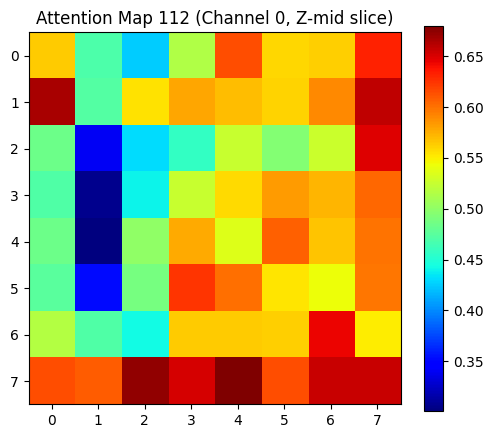

Attention map 113 shape: (1, 1, 8, 8, 8)


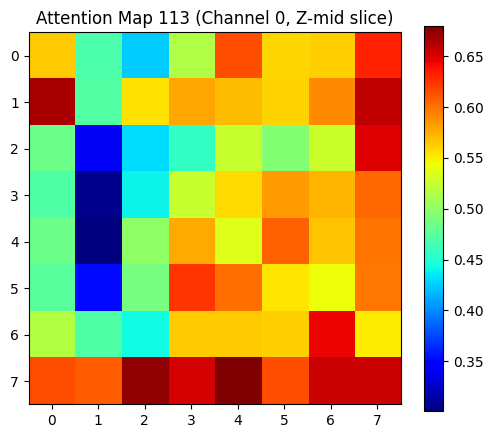

Attention map 114 shape: (1, 1, 8, 8, 8)


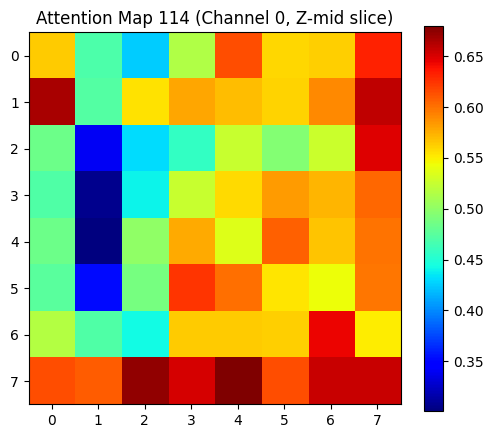

Attention map 115 shape: (1, 1, 8, 8, 8)


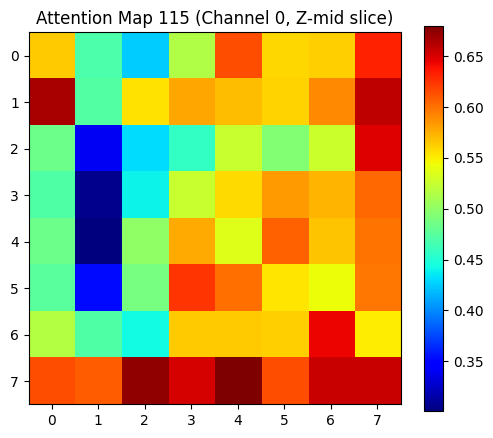

Attention map 116 shape: (1, 64, 8, 8, 8)


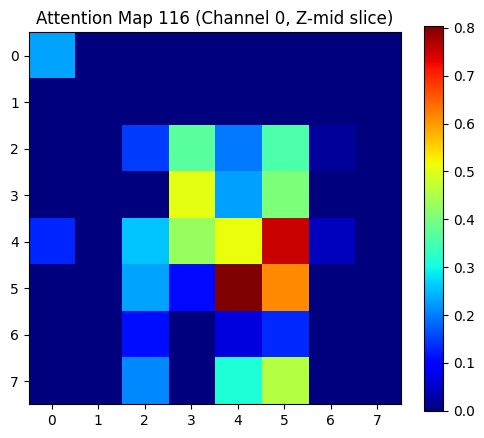

Attention map 117 shape: (1, 64, 8, 8, 8)


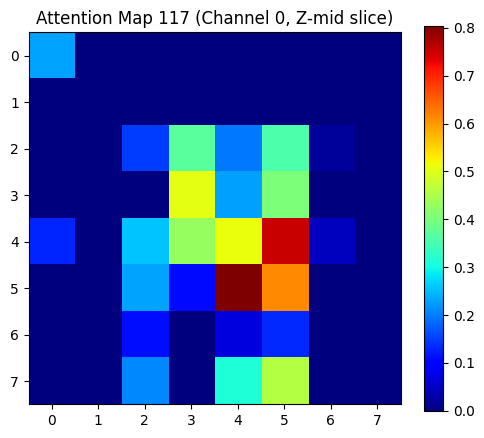

Attention map 118 shape: (1, 64, 8, 8, 8)


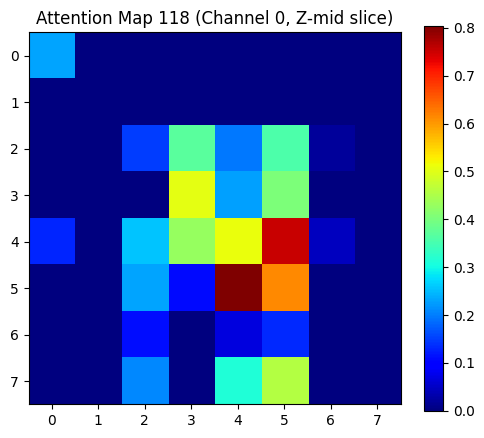

Attention map 119 shape: (1, 64, 8, 8, 8)


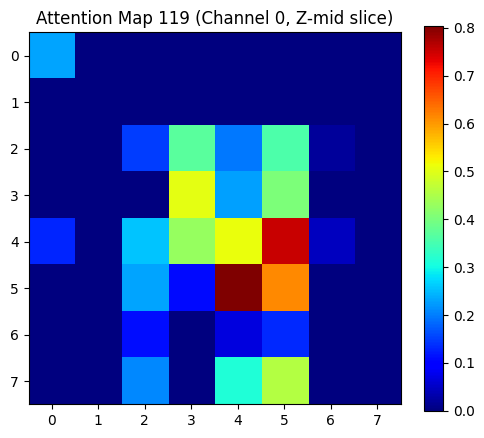

Attention map 120 shape: (1, 16, 16, 16, 16)


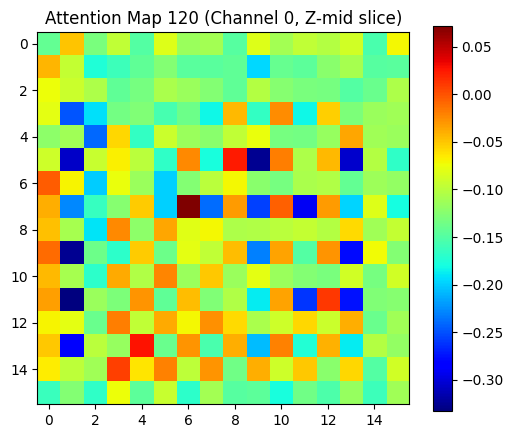

Attention map 121 shape: (1, 16, 16, 16, 16)


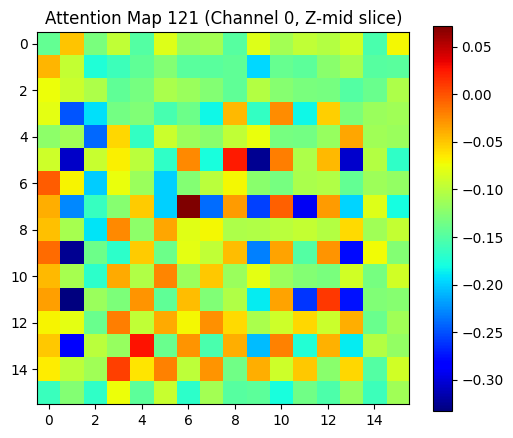

Attention map 122 shape: (1, 16, 16, 16, 16)


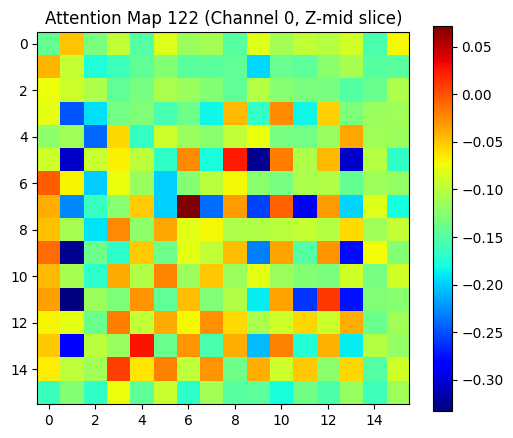

Attention map 123 shape: (1, 16, 16, 16, 16)


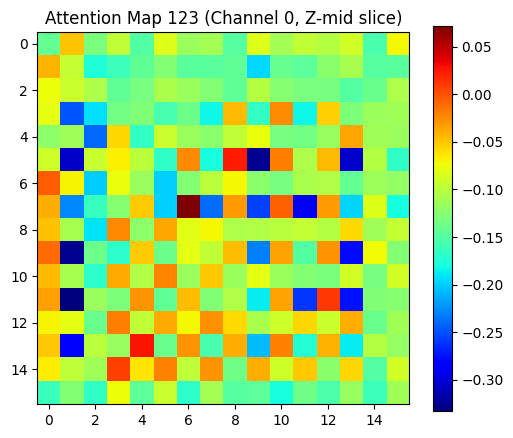

Attention map 124 shape: (1, 16, 16, 16, 16)


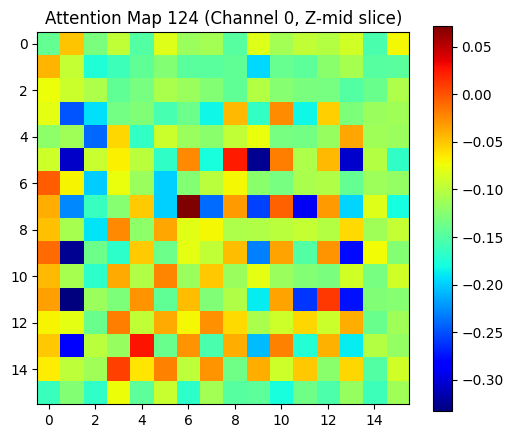

Attention map 125 shape: (1, 16, 16, 16, 16)


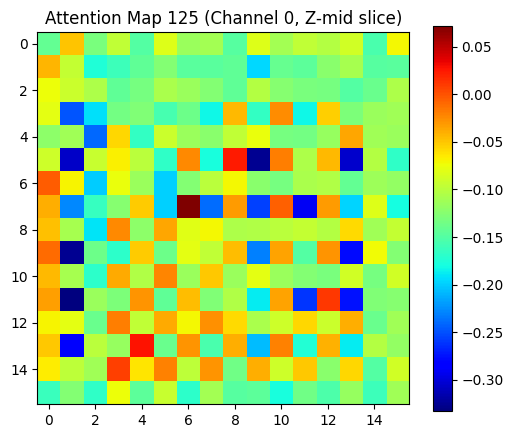

Attention map 126 shape: (1, 16, 16, 16, 16)


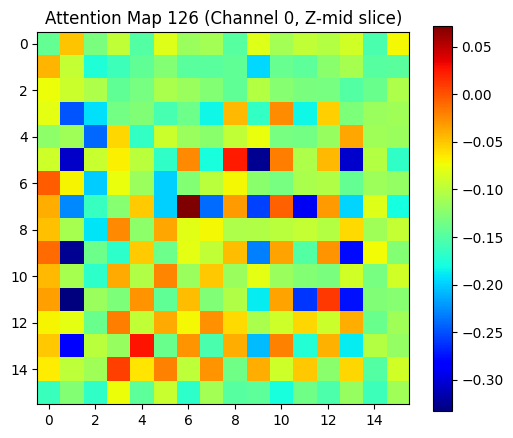

Attention map 127 shape: (1, 16, 16, 16, 16)


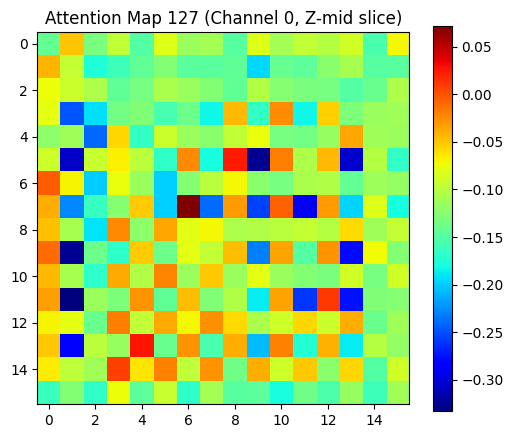

Attention map 128 shape: (1, 16, 16, 16, 16)


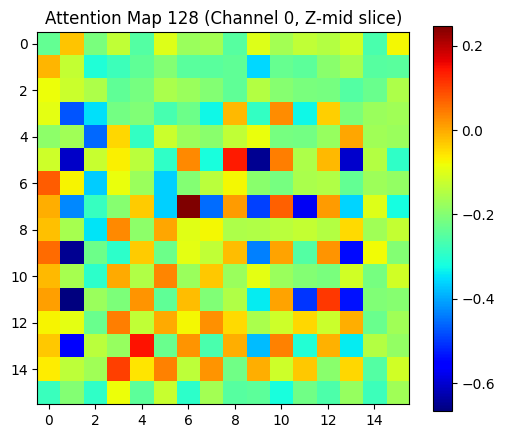

Attention map 129 shape: (1, 16, 16, 16, 16)


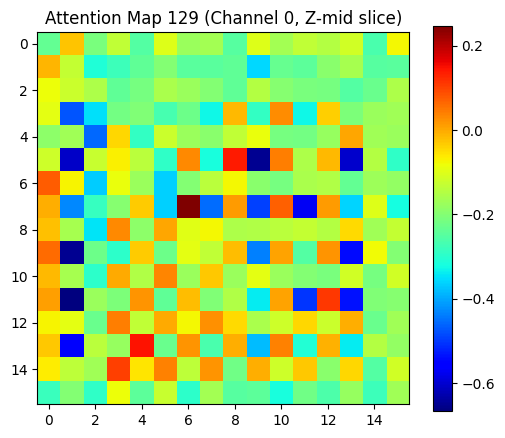

Attention map 130 shape: (1, 16, 16, 16, 16)


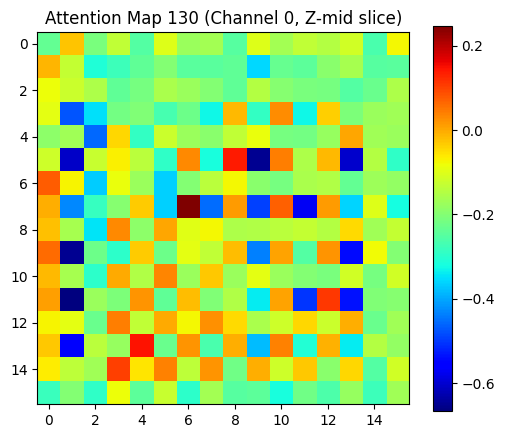

Attention map 131 shape: (1, 16, 16, 16, 16)


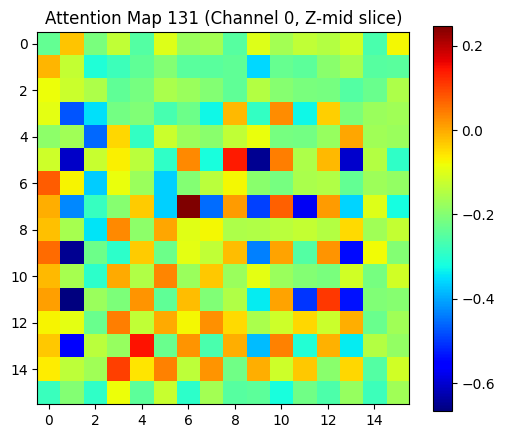

Attention map 132 shape: (1, 16, 16, 16, 16)


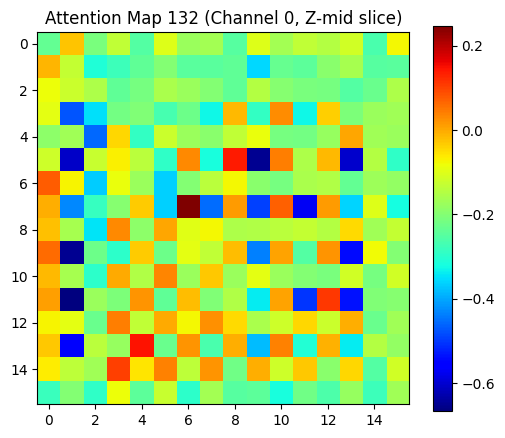

Attention map 133 shape: (1, 16, 16, 16, 16)


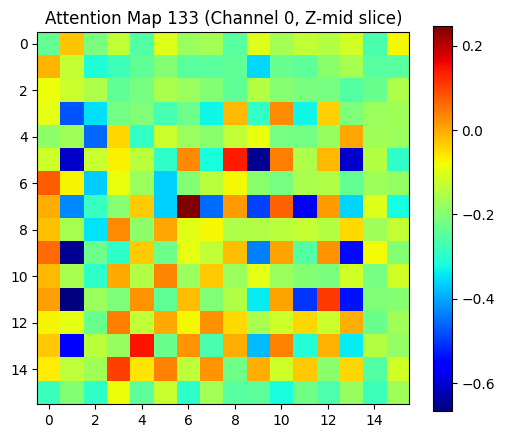

Attention map 134 shape: (1, 16, 16, 16, 16)


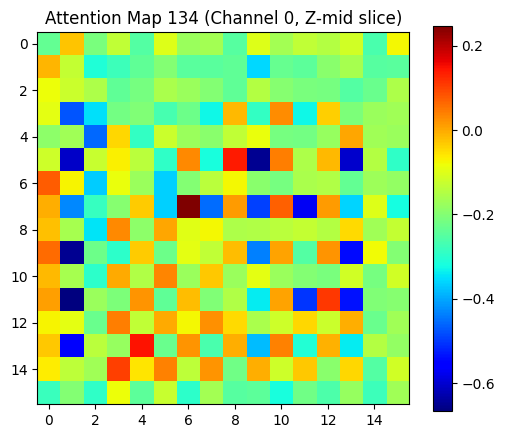

Attention map 135 shape: (1, 16, 16, 16, 16)


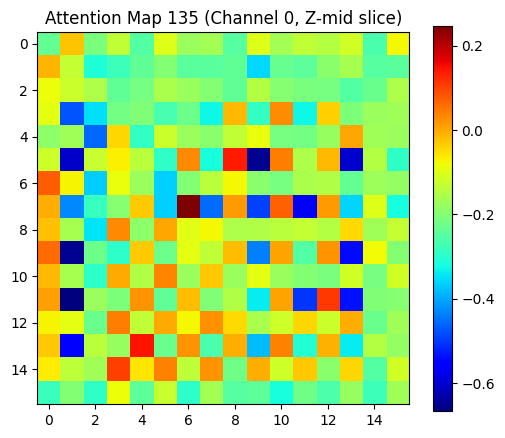

Attention map 136 shape: (1, 16, 16, 16, 16)


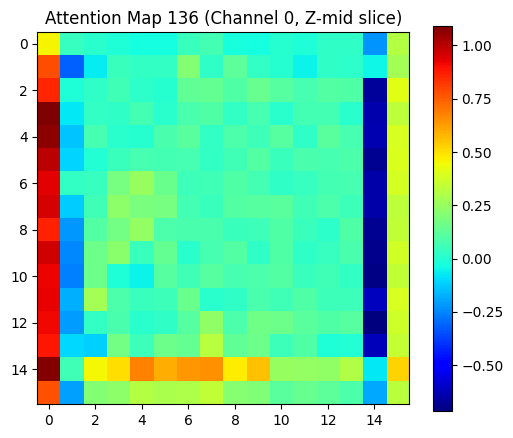

Attention map 137 shape: (1, 16, 16, 16, 16)


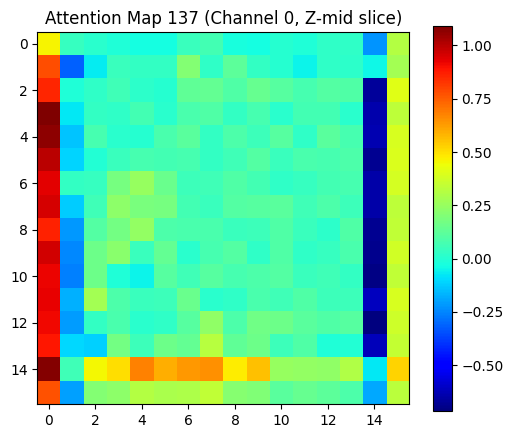

Attention map 138 shape: (1, 16, 16, 16, 16)


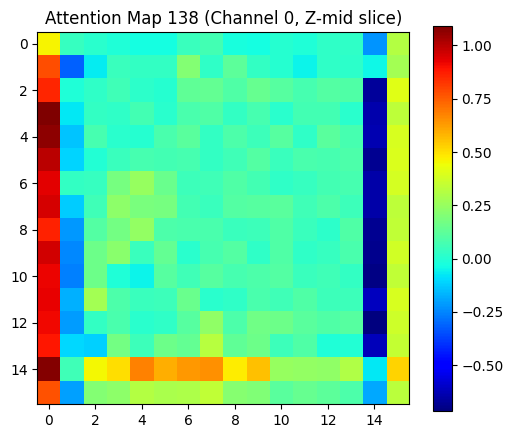

Attention map 139 shape: (1, 16, 16, 16, 16)


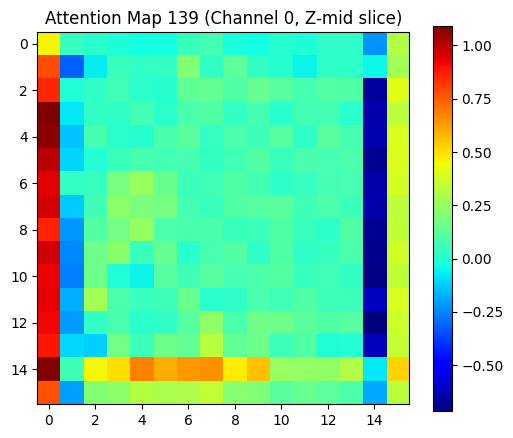

Attention map 140 shape: (1, 16, 16, 16, 16)


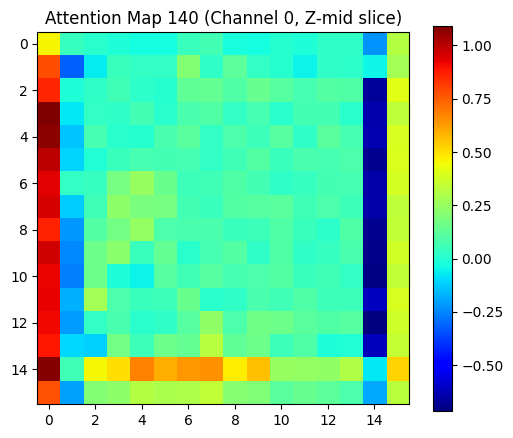

Attention map 141 shape: (1, 16, 16, 16, 16)


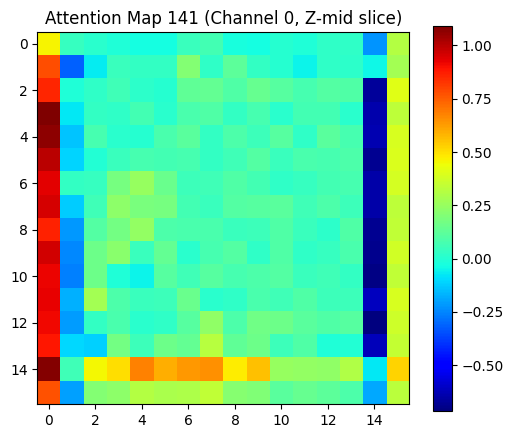

Attention map 142 shape: (1, 16, 16, 16, 16)


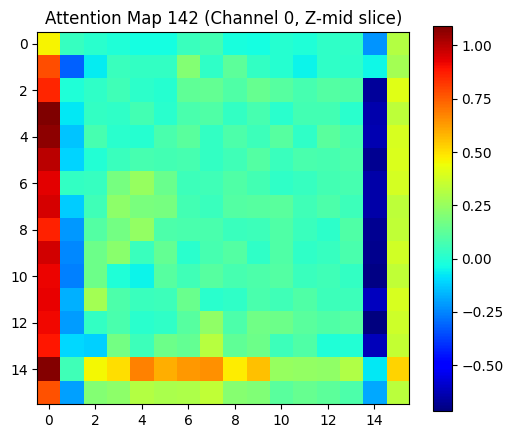

Attention map 143 shape: (1, 16, 16, 16, 16)


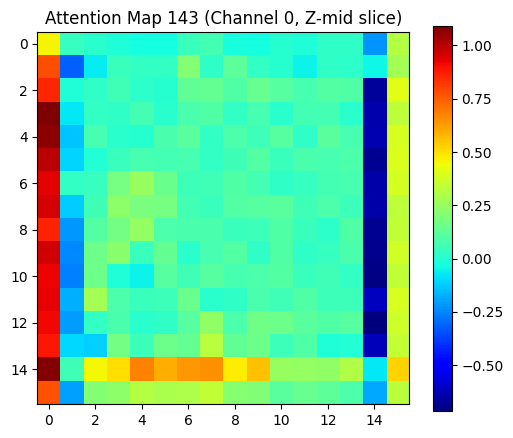

Attention map 144 shape: (1, 16, 16, 16, 16)


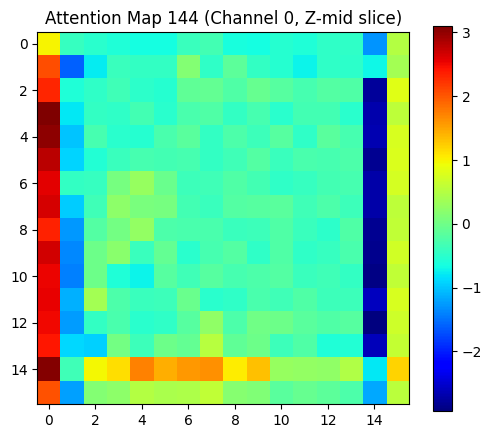

Attention map 145 shape: (1, 16, 16, 16, 16)


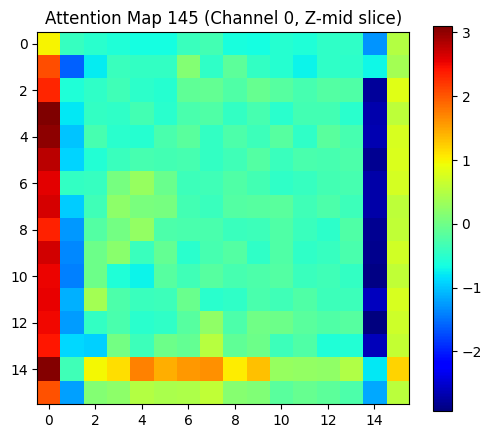

Attention map 146 shape: (1, 16, 16, 16, 16)


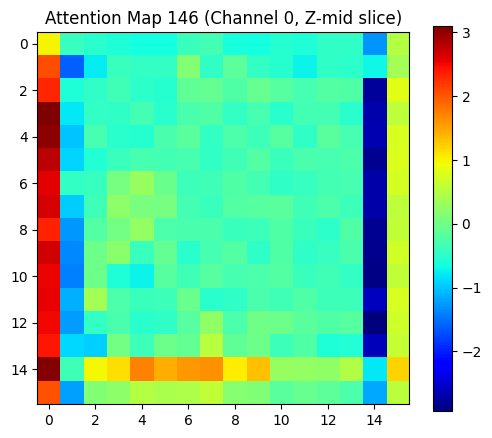

Attention map 147 shape: (1, 16, 16, 16, 16)


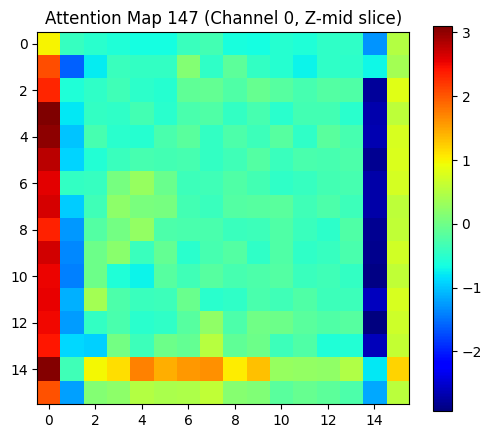

Attention map 148 shape: (1, 16, 16, 16, 16)


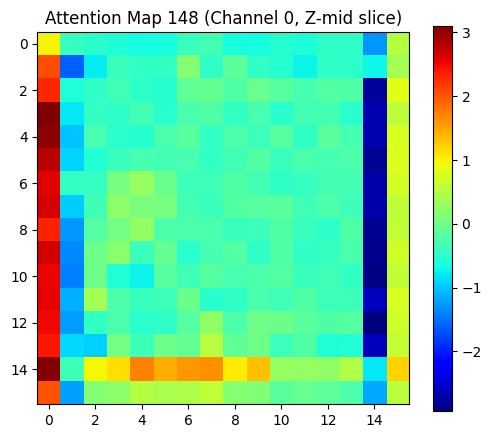

Attention map 149 shape: (1, 16, 16, 16, 16)


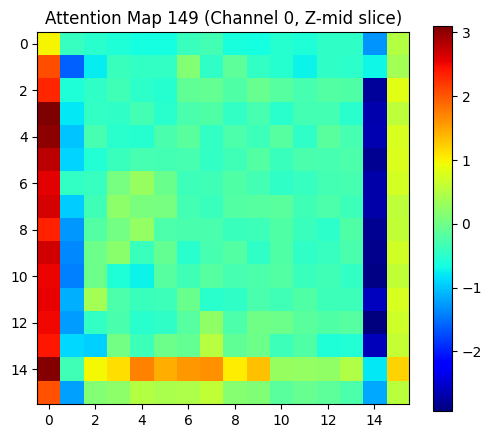

Attention map 150 shape: (1, 16, 16, 16, 16)


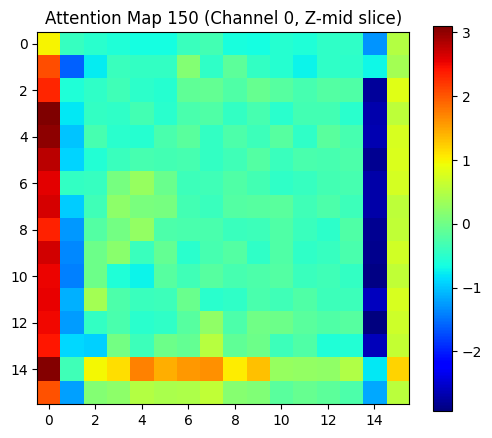

Attention map 151 shape: (1, 16, 16, 16, 16)


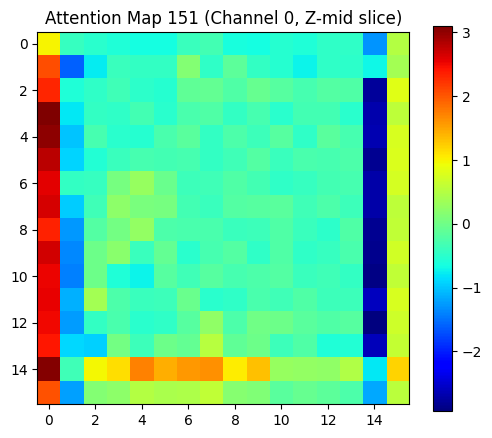

Attention map 152 shape: (1, 16, 16, 16, 16)


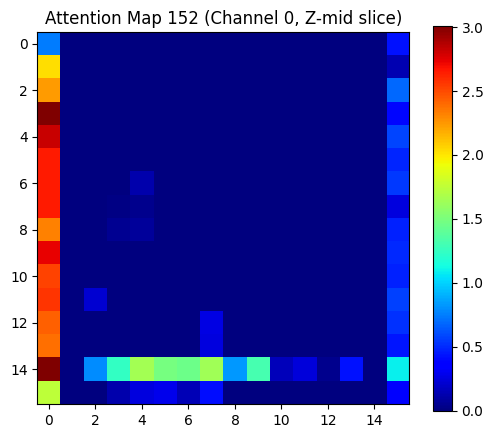

Attention map 153 shape: (1, 16, 16, 16, 16)


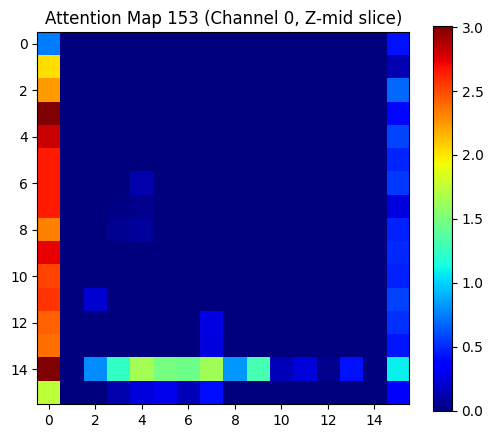

Attention map 154 shape: (1, 16, 16, 16, 16)


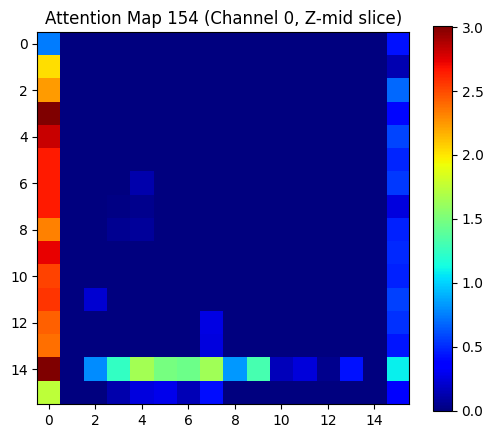

Attention map 155 shape: (1, 16, 16, 16, 16)


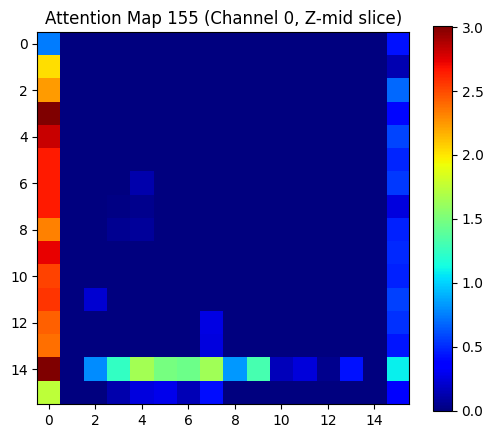

Attention map 156 shape: (1, 1, 16, 16, 16)


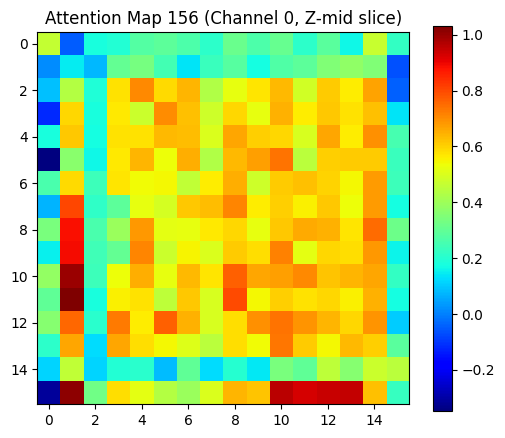

Attention map 157 shape: (1, 1, 16, 16, 16)


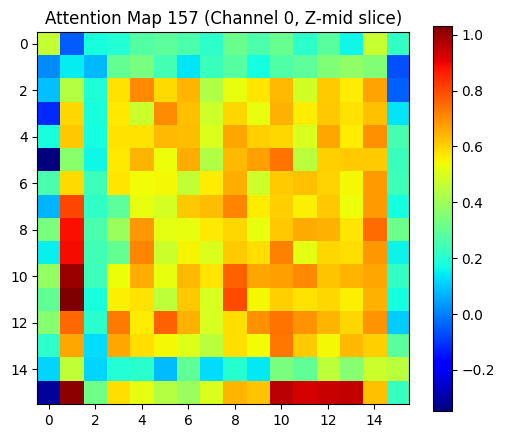

Attention map 158 shape: (1, 1, 16, 16, 16)


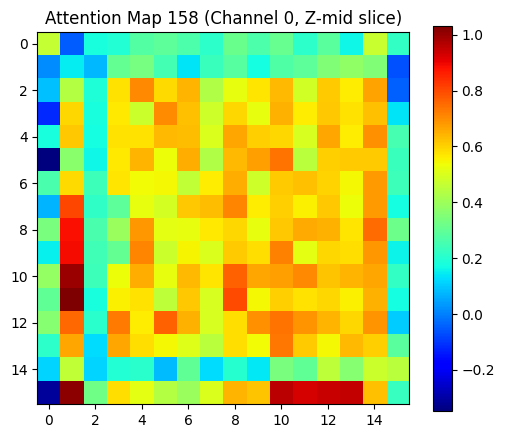

Attention map 159 shape: (1, 1, 16, 16, 16)


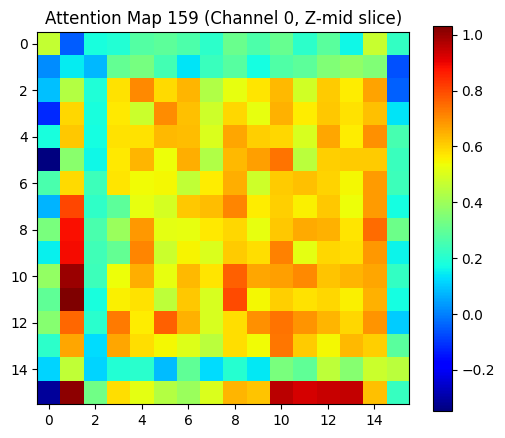

Attention map 160 shape: (1, 1, 16, 16, 16)


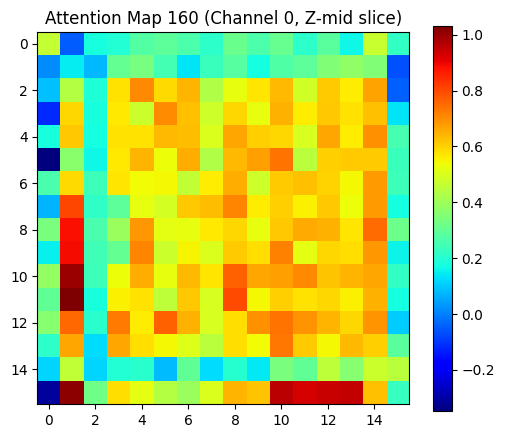

Attention map 161 shape: (1, 1, 16, 16, 16)


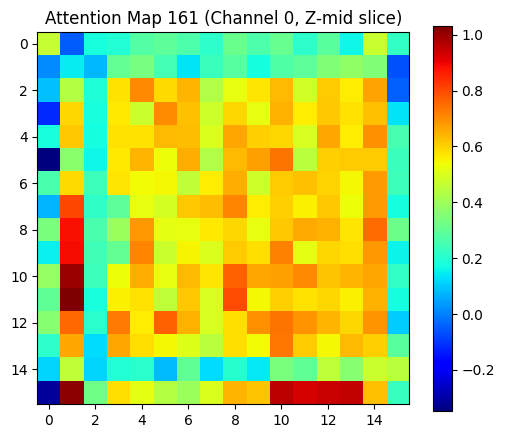

Attention map 162 shape: (1, 1, 16, 16, 16)


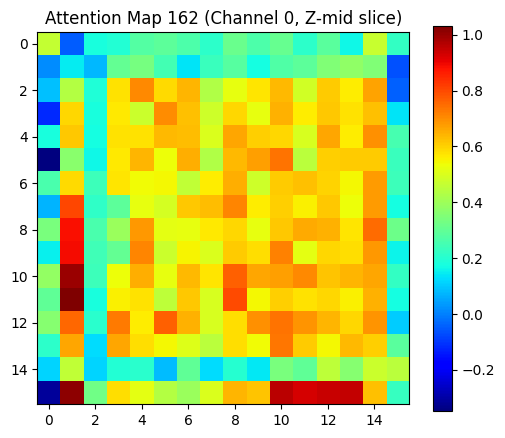

Attention map 163 shape: (1, 1, 16, 16, 16)


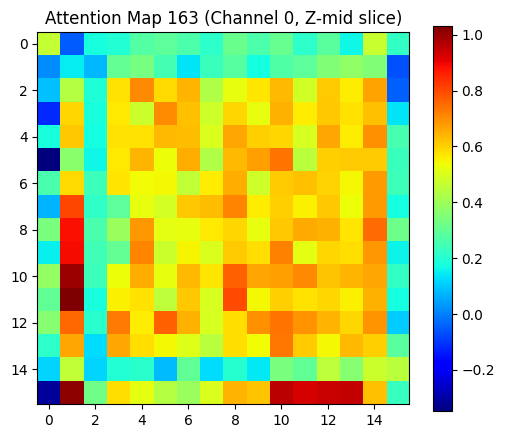

Attention map 164 shape: (1, 1, 16, 16, 16)


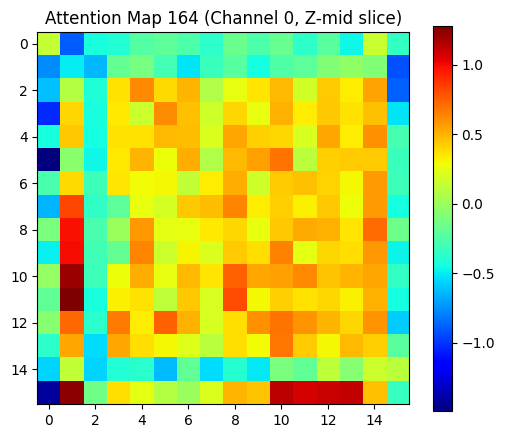

Attention map 165 shape: (1, 1, 16, 16, 16)


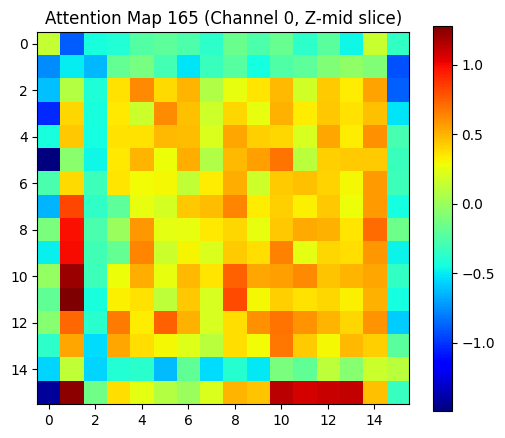

Attention map 166 shape: (1, 1, 16, 16, 16)


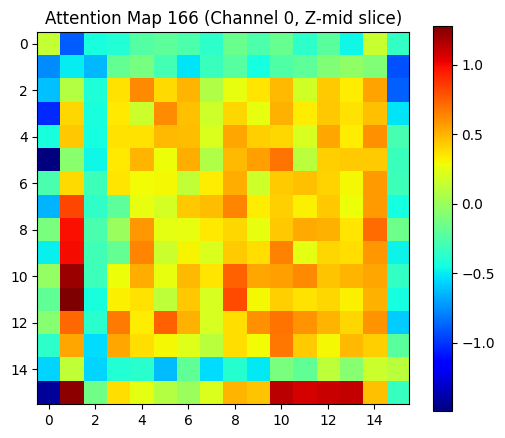

Attention map 167 shape: (1, 1, 16, 16, 16)


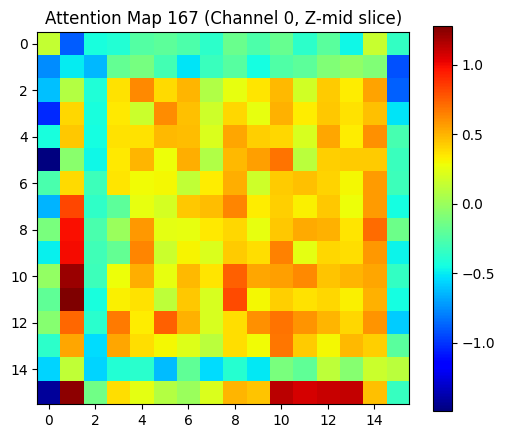

Attention map 168 shape: (1, 1, 16, 16, 16)


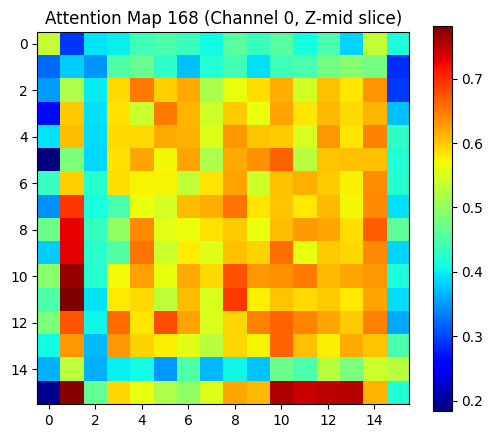

Attention map 169 shape: (1, 1, 16, 16, 16)


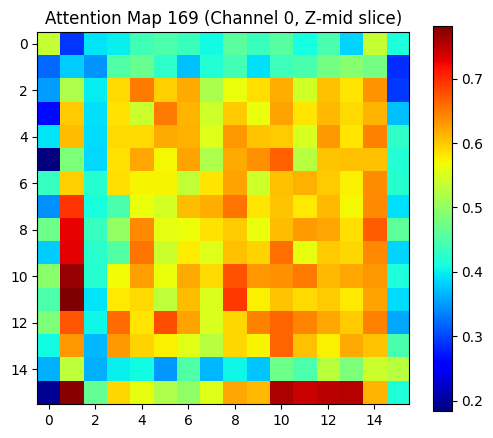

Attention map 170 shape: (1, 1, 16, 16, 16)


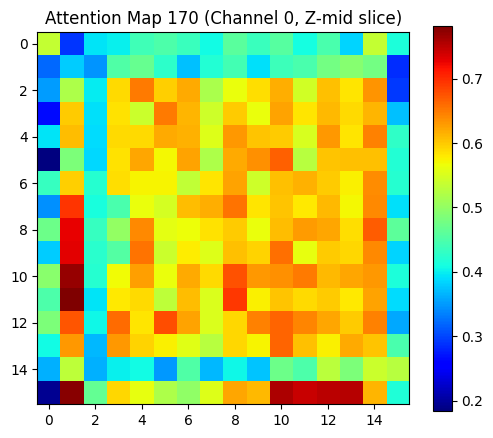

Attention map 171 shape: (1, 1, 16, 16, 16)


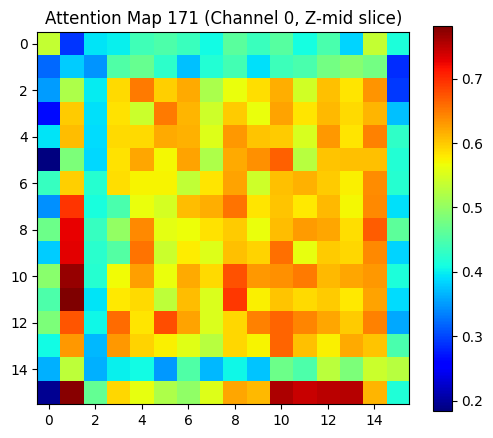

Attention map 172 shape: (1, 1, 16, 16, 16)


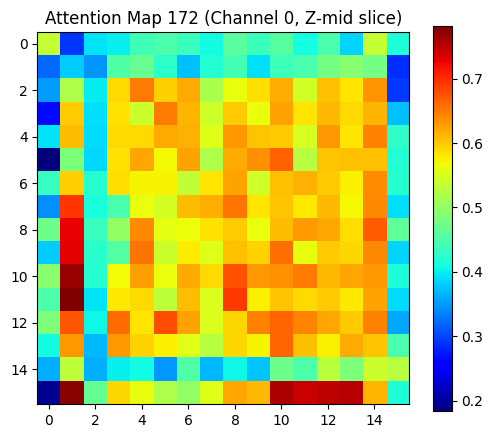

Attention map 173 shape: (1, 1, 16, 16, 16)


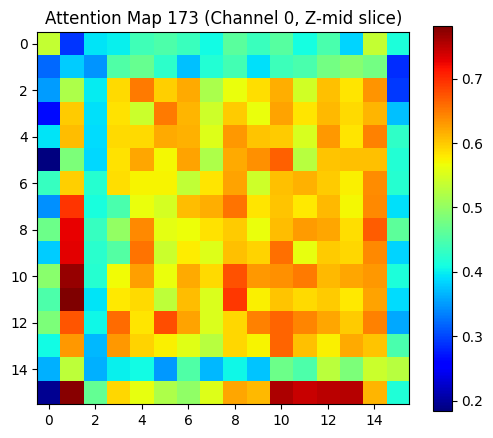

Attention map 174 shape: (1, 1, 16, 16, 16)


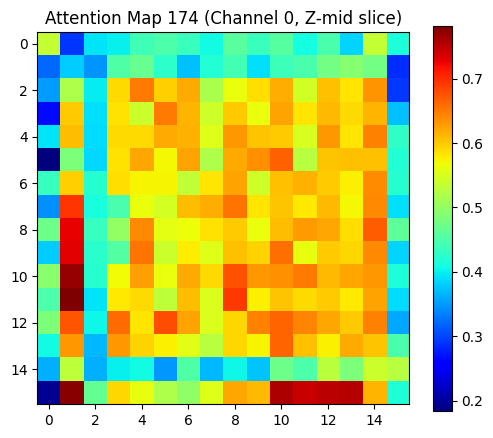

Attention map 175 shape: (1, 1, 16, 16, 16)


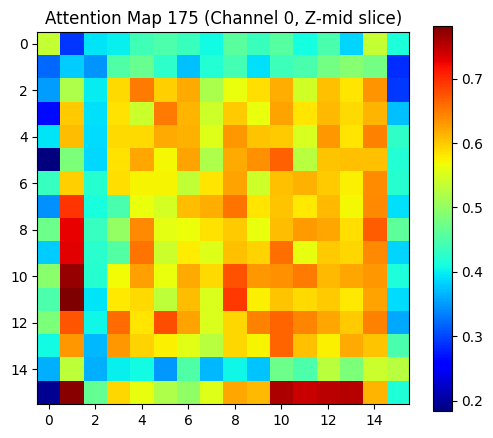

Attention map 176 shape: (1, 32, 16, 16, 16)


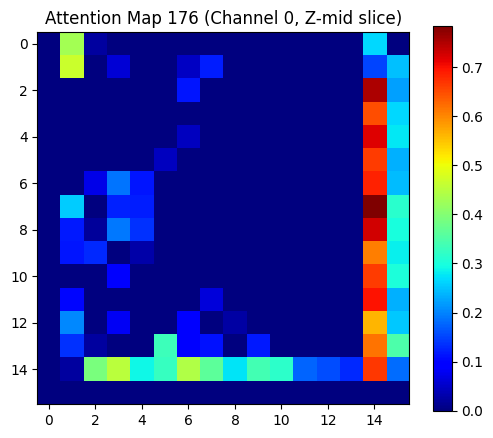

Attention map 177 shape: (1, 32, 16, 16, 16)


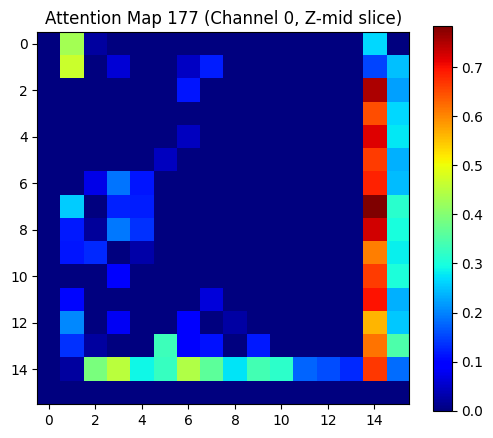

Attention map 178 shape: (1, 32, 16, 16, 16)


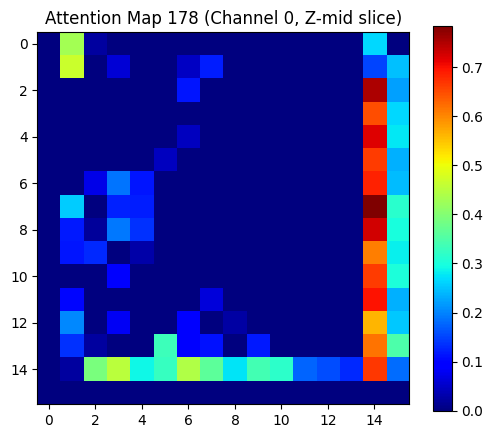

Attention map 179 shape: (1, 32, 16, 16, 16)


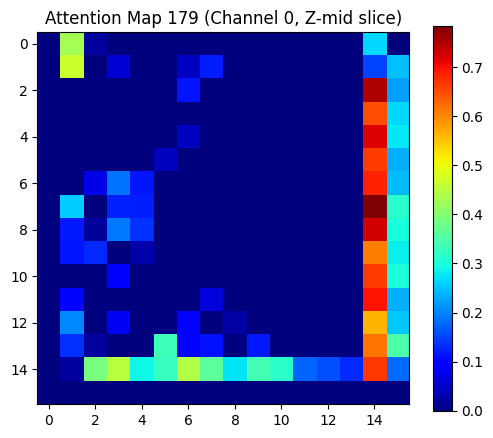

Attention map 180 shape: (1, 8, 32, 32, 32)


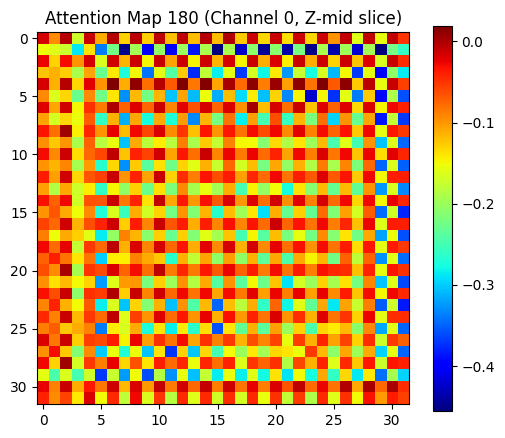

Attention map 181 shape: (1, 8, 32, 32, 32)


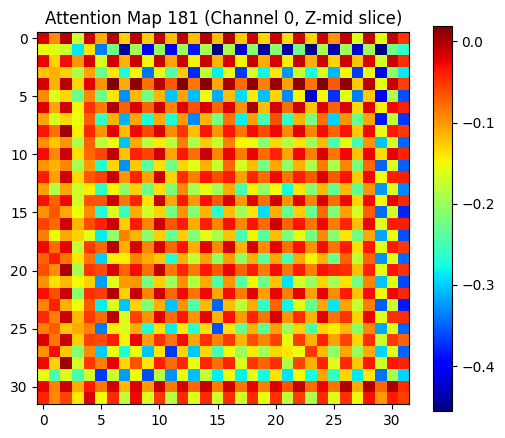

Attention map 182 shape: (1, 8, 32, 32, 32)


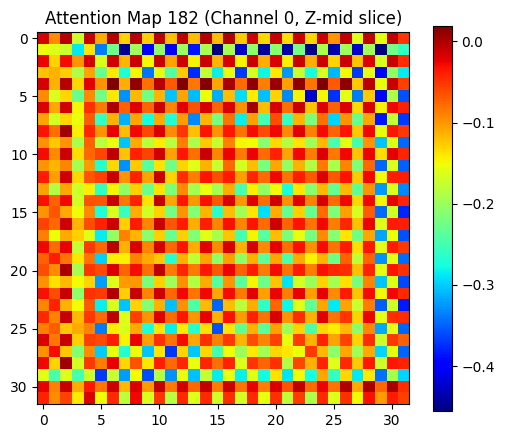

Attention map 183 shape: (1, 8, 32, 32, 32)


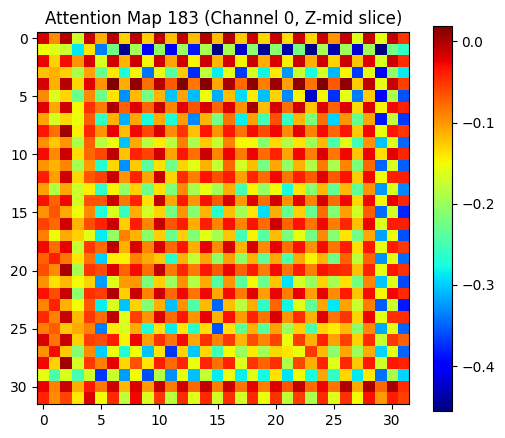

Attention map 184 shape: (1, 8, 32, 32, 32)


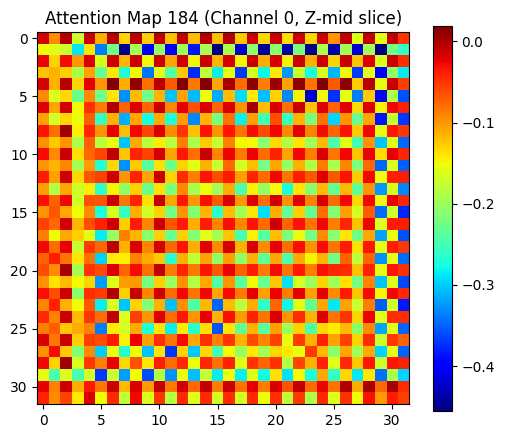

Attention map 185 shape: (1, 8, 32, 32, 32)


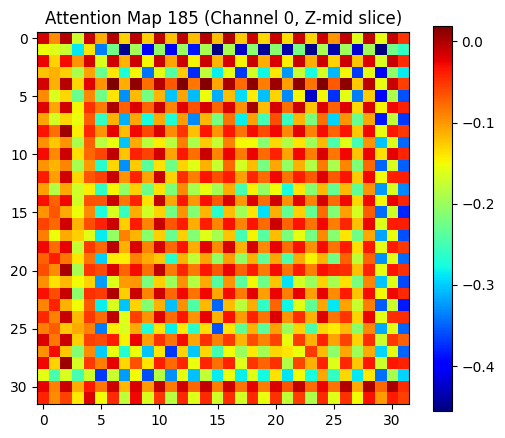

Attention map 186 shape: (1, 8, 32, 32, 32)


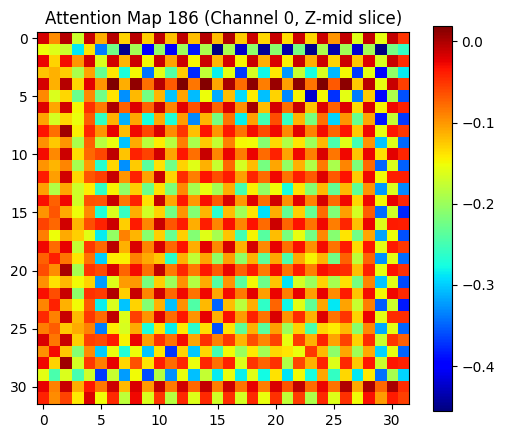

Attention map 187 shape: (1, 8, 32, 32, 32)


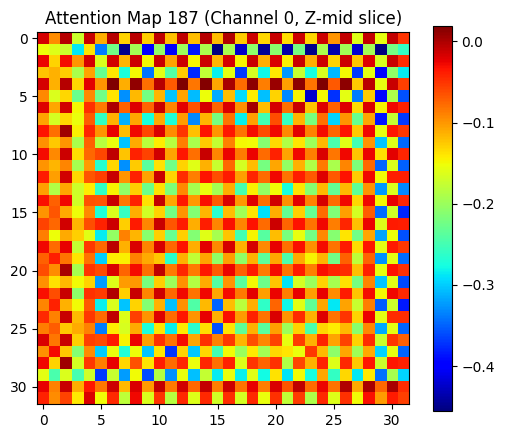

Attention map 188 shape: (1, 8, 32, 32, 32)


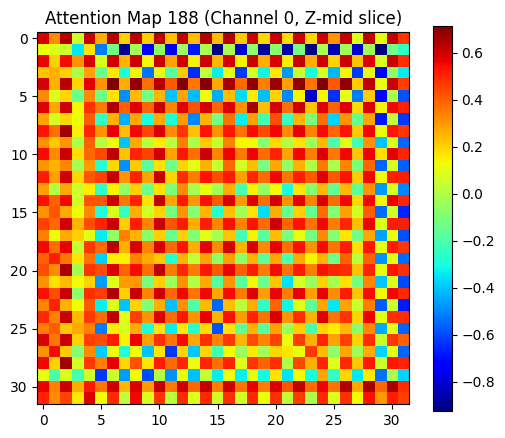

Attention map 189 shape: (1, 8, 32, 32, 32)


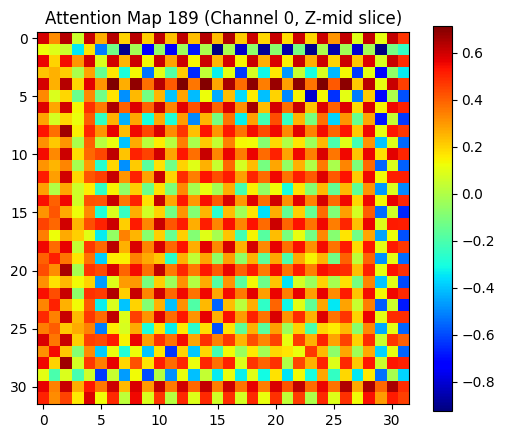

Attention map 190 shape: (1, 8, 32, 32, 32)


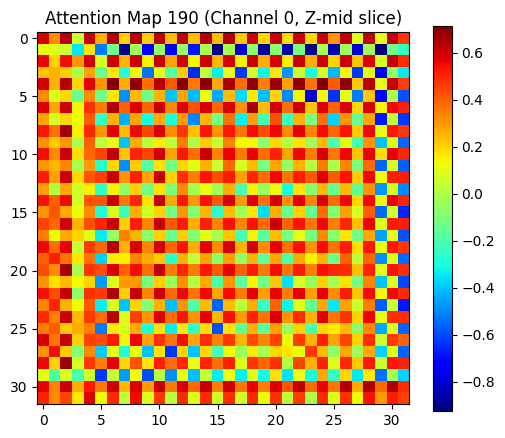

Attention map 191 shape: (1, 8, 32, 32, 32)


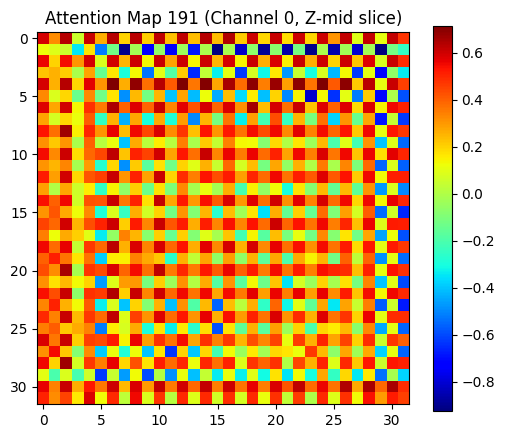

Attention map 192 shape: (1, 8, 32, 32, 32)


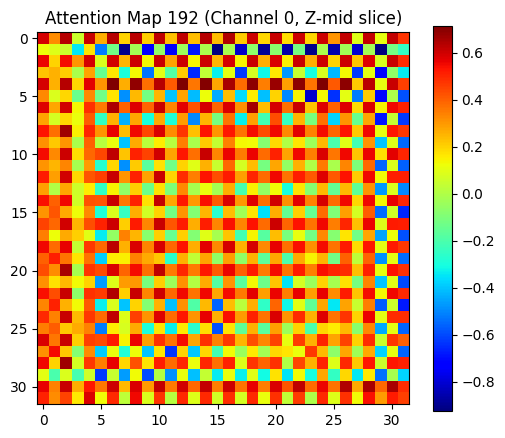

Attention map 193 shape: (1, 8, 32, 32, 32)


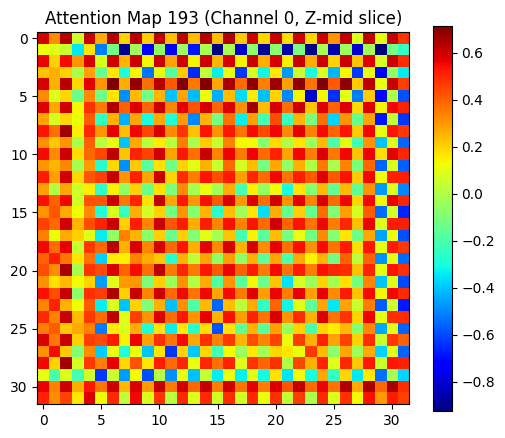

Attention map 194 shape: (1, 8, 32, 32, 32)


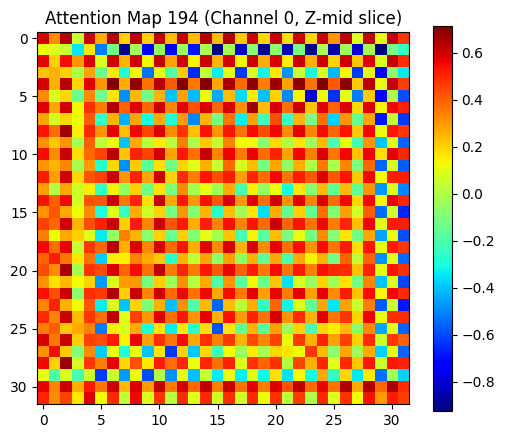

Attention map 195 shape: (1, 8, 32, 32, 32)


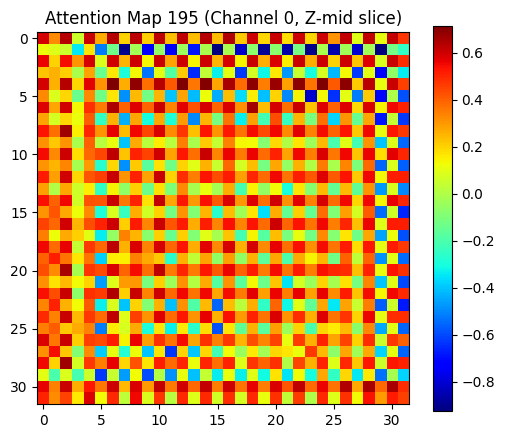

Attention map 196 shape: (1, 8, 32, 32, 32)


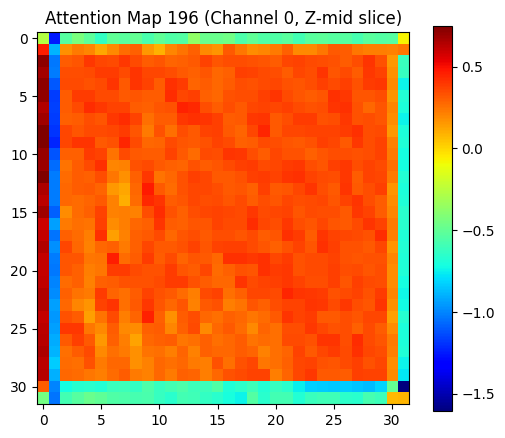

Attention map 197 shape: (1, 8, 32, 32, 32)


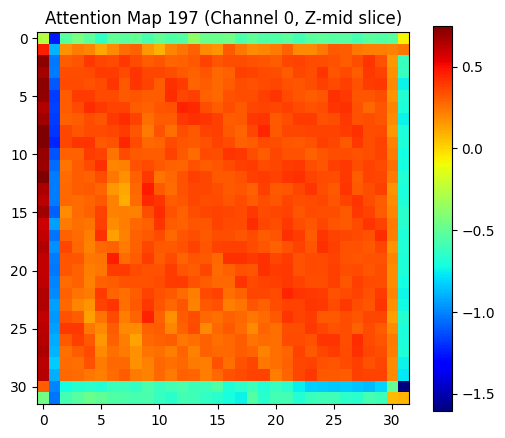

Attention map 198 shape: (1, 8, 32, 32, 32)


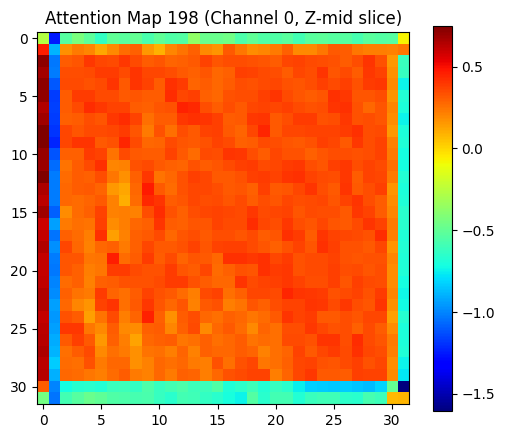

Attention map 199 shape: (1, 8, 32, 32, 32)


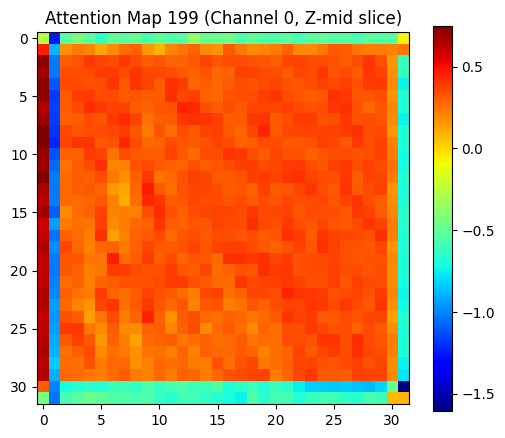

Attention map 200 shape: (1, 8, 32, 32, 32)


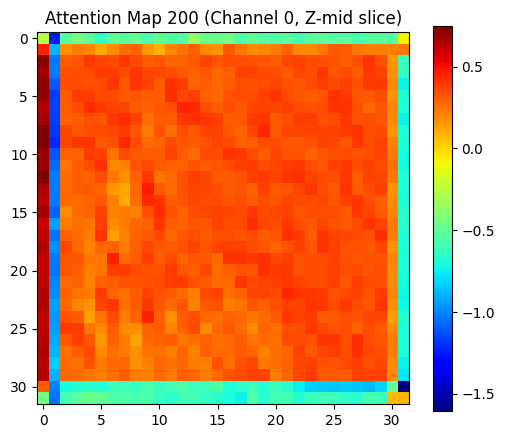

Attention map 201 shape: (1, 8, 32, 32, 32)


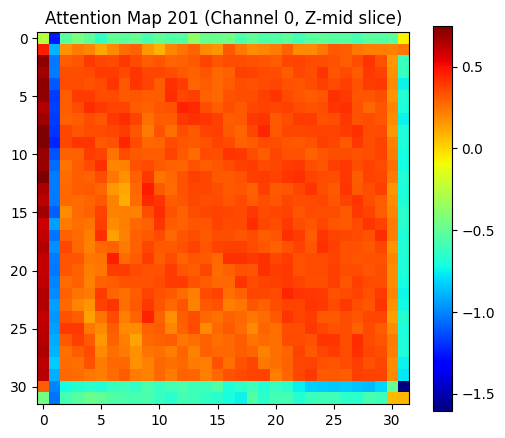

Attention map 202 shape: (1, 8, 32, 32, 32)


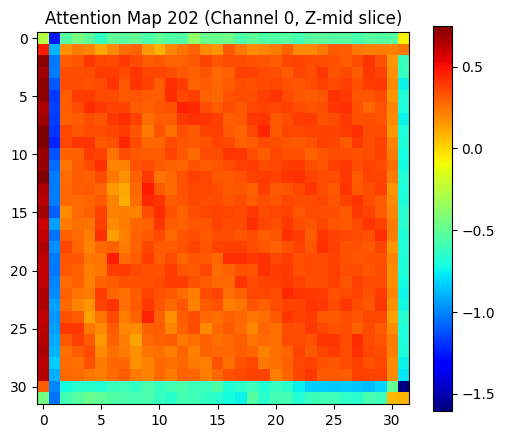

Attention map 203 shape: (1, 8, 32, 32, 32)


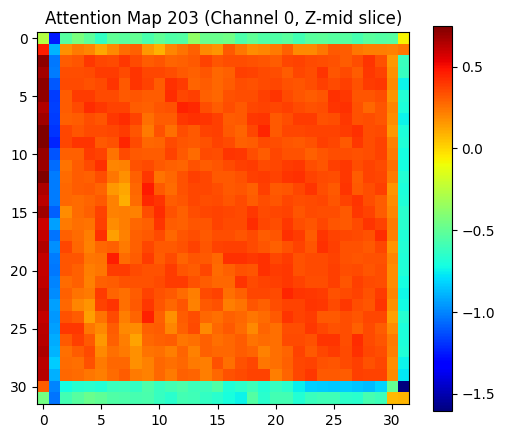

Attention map 204 shape: (1, 8, 32, 32, 32)


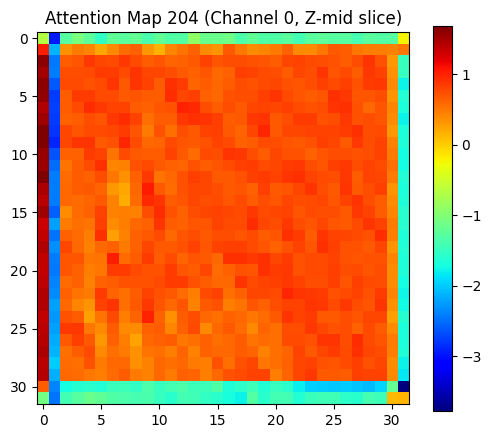

Attention map 205 shape: (1, 8, 32, 32, 32)


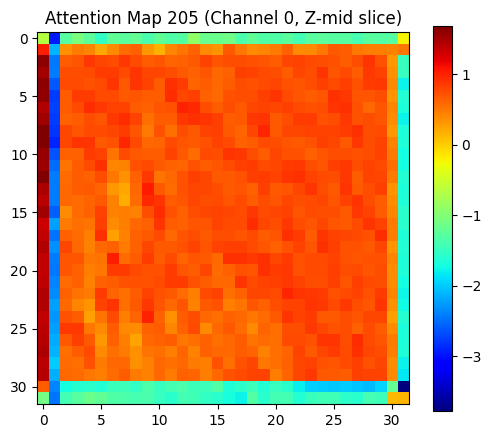

Attention map 206 shape: (1, 8, 32, 32, 32)


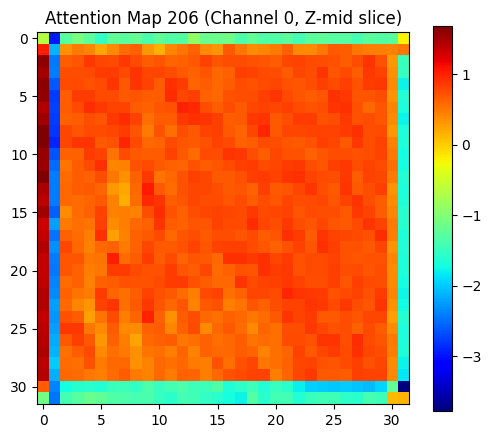

Attention map 207 shape: (1, 8, 32, 32, 32)


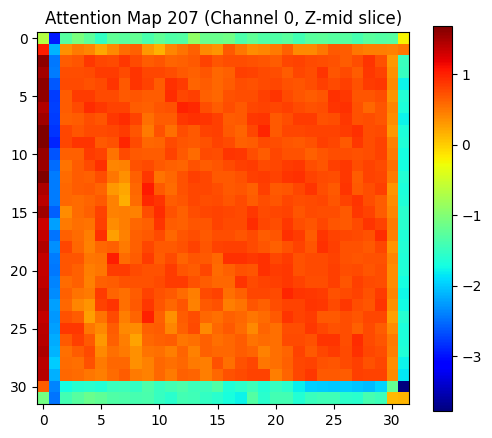

Attention map 208 shape: (1, 8, 32, 32, 32)


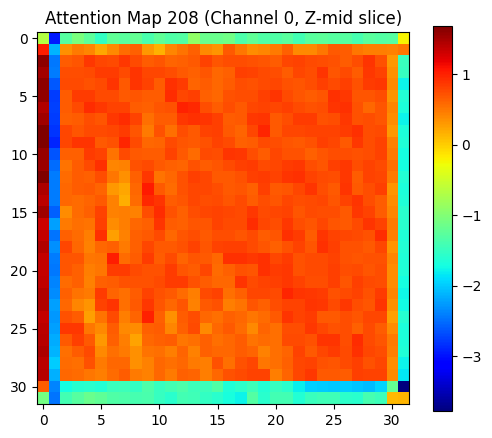

Attention map 209 shape: (1, 8, 32, 32, 32)


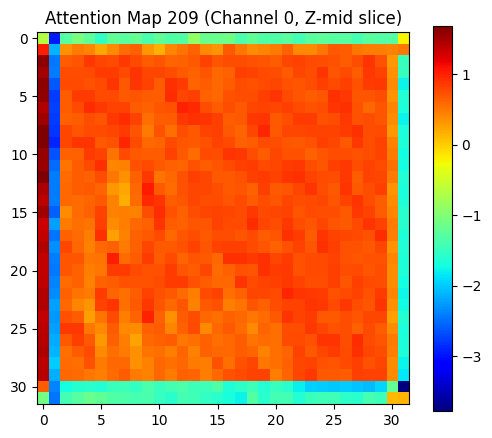

Attention map 210 shape: (1, 8, 32, 32, 32)


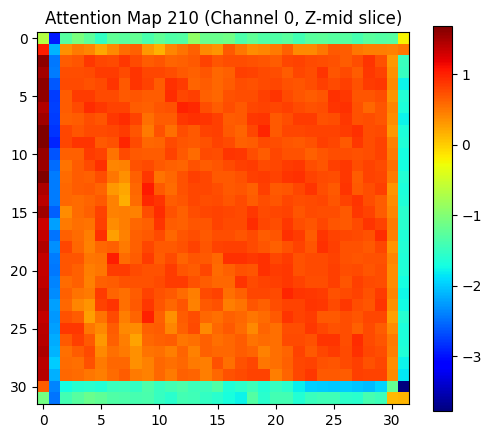

Attention map 211 shape: (1, 8, 32, 32, 32)


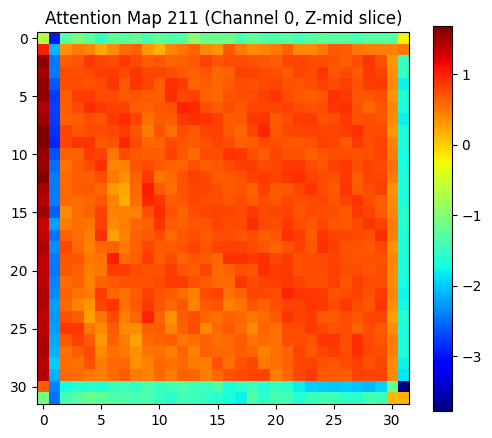

Attention map 212 shape: (1, 8, 32, 32, 32)


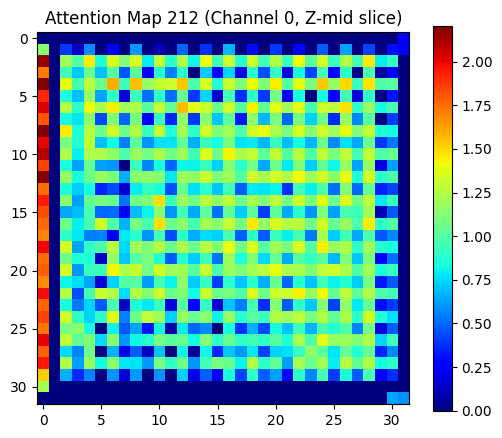

Attention map 213 shape: (1, 8, 32, 32, 32)


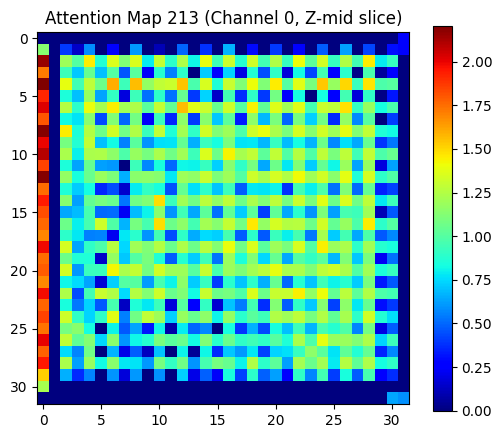

Attention map 214 shape: (1, 8, 32, 32, 32)


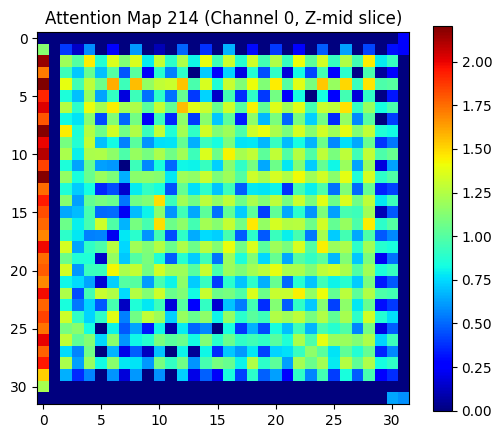

Attention map 215 shape: (1, 8, 32, 32, 32)


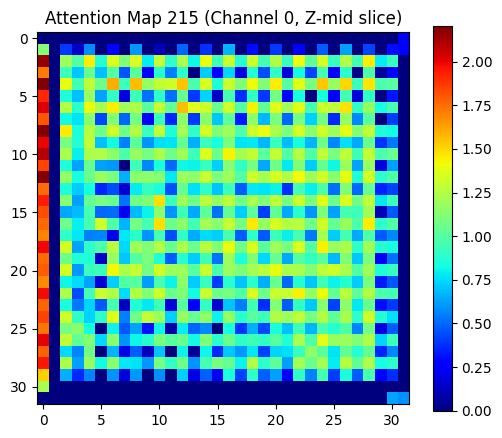

Attention map 216 shape: (1, 1, 32, 32, 32)


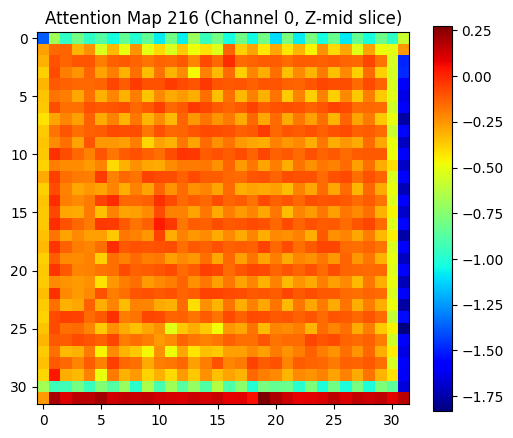

Attention map 217 shape: (1, 1, 32, 32, 32)


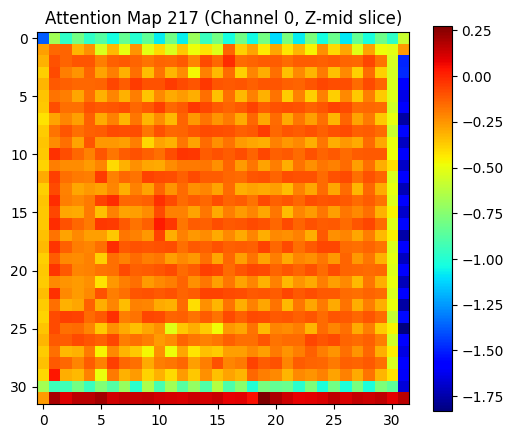

Attention map 218 shape: (1, 1, 32, 32, 32)


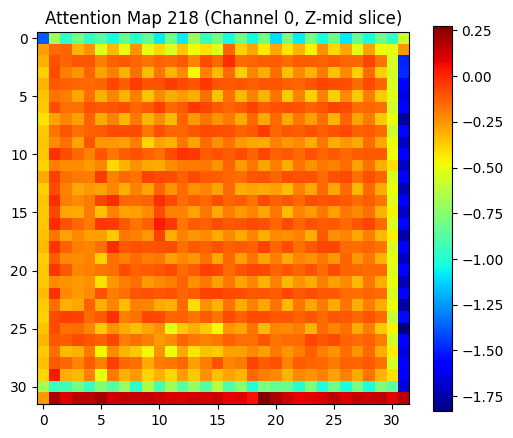

Attention map 219 shape: (1, 1, 32, 32, 32)


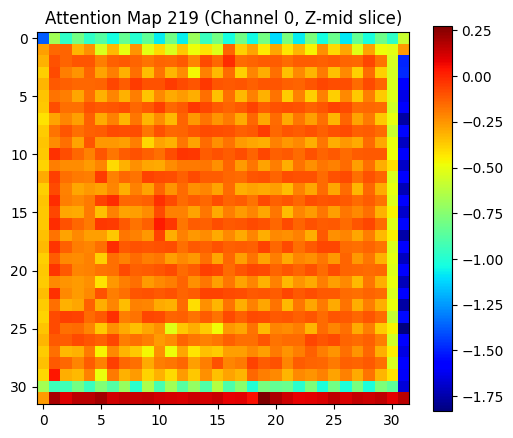

Attention map 220 shape: (1, 1, 32, 32, 32)


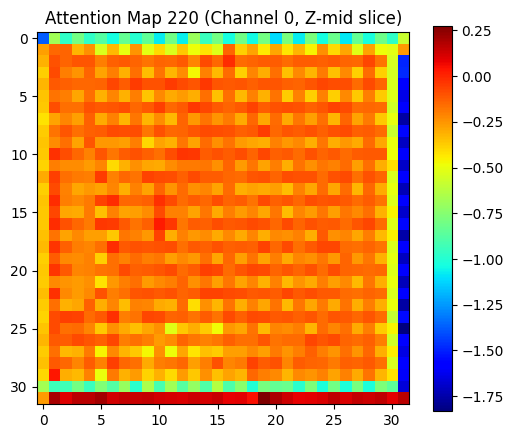

Attention map 221 shape: (1, 1, 32, 32, 32)


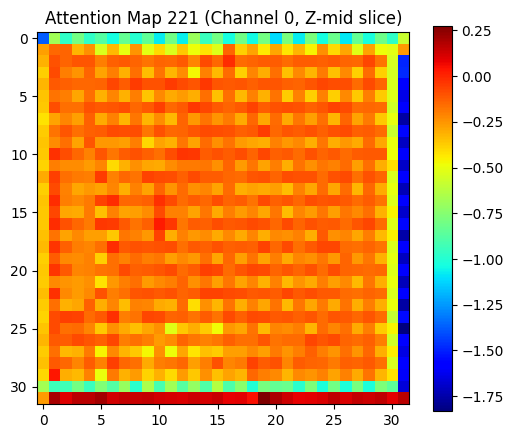

Attention map 222 shape: (1, 1, 32, 32, 32)


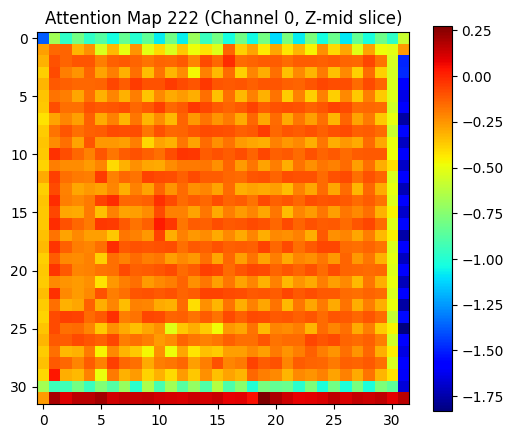

Attention map 223 shape: (1, 1, 32, 32, 32)


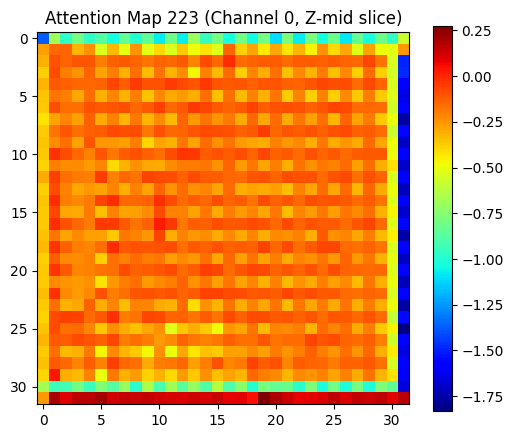

Attention map 224 shape: (1, 1, 32, 32, 32)


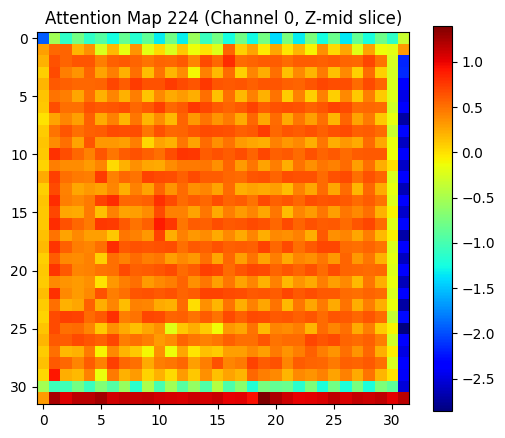

Attention map 225 shape: (1, 1, 32, 32, 32)


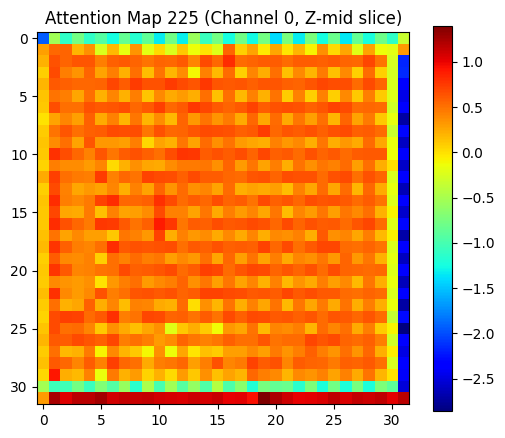

Attention map 226 shape: (1, 1, 32, 32, 32)


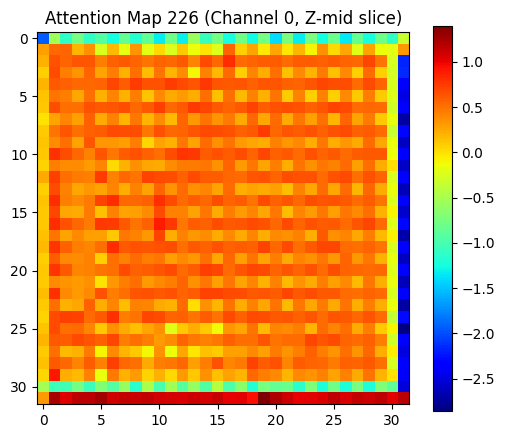

Attention map 227 shape: (1, 1, 32, 32, 32)


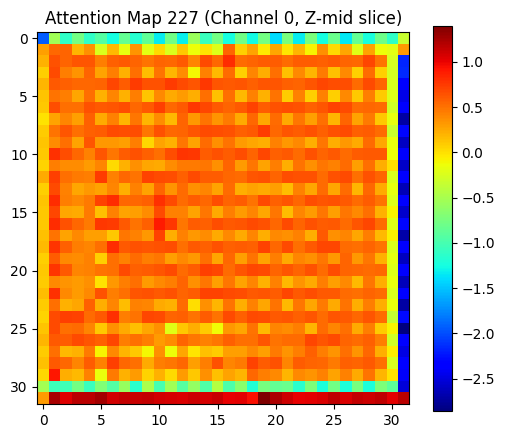

Attention map 228 shape: (1, 1, 32, 32, 32)


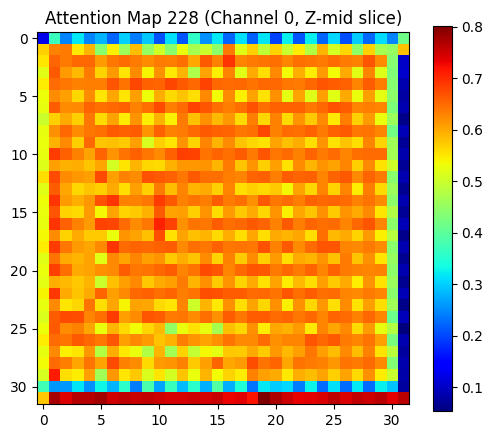

Attention map 229 shape: (1, 1, 32, 32, 32)


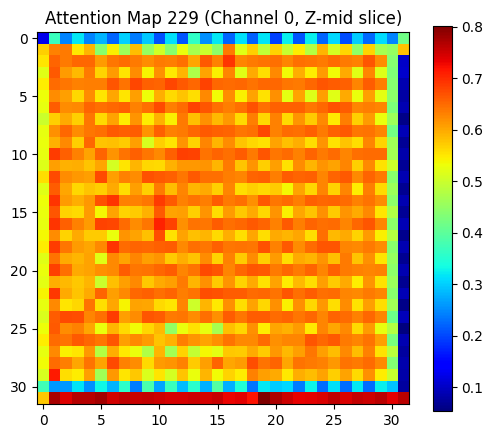

Attention map 230 shape: (1, 1, 32, 32, 32)


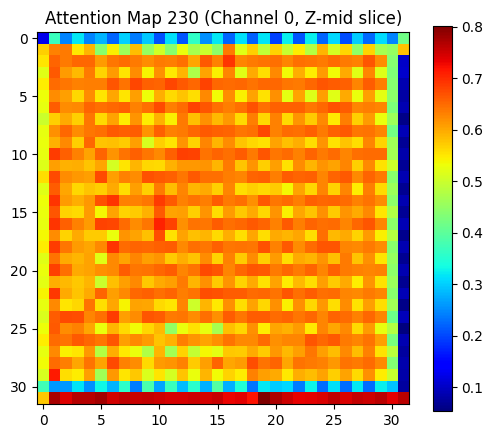

Attention map 231 shape: (1, 1, 32, 32, 32)


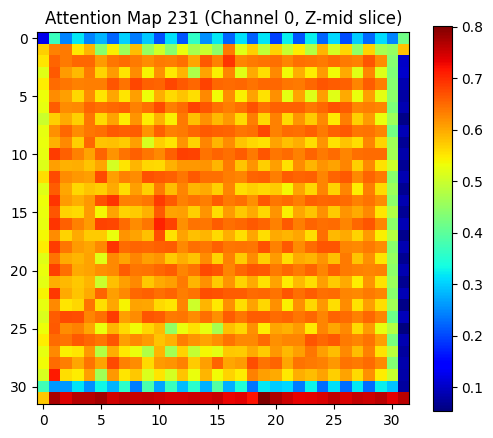

Attention map 232 shape: (1, 1, 32, 32, 32)


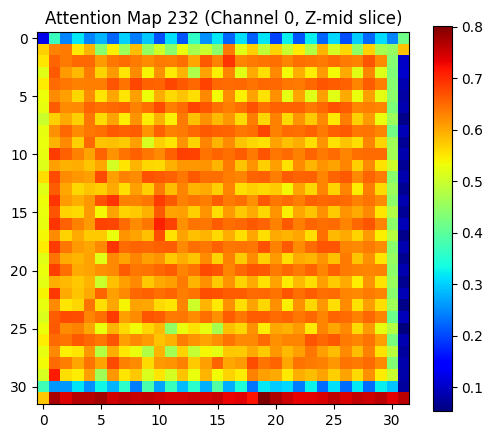

Attention map 233 shape: (1, 1, 32, 32, 32)


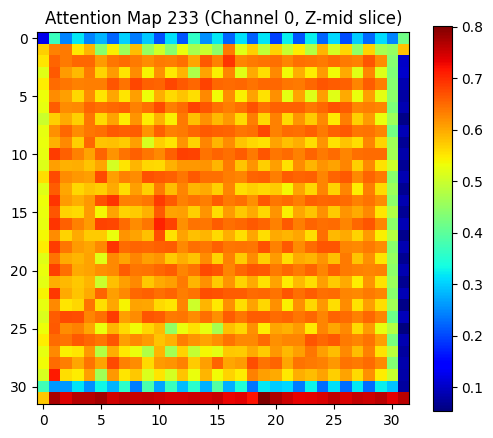

Attention map 234 shape: (1, 1, 32, 32, 32)


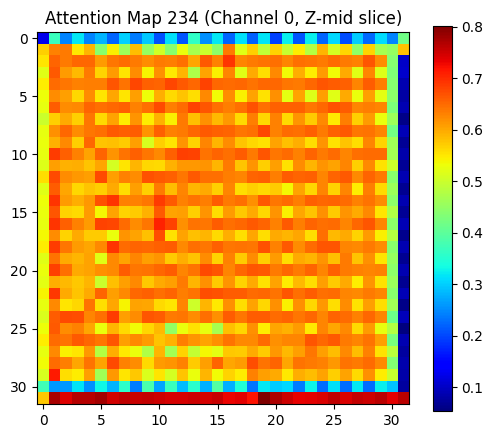

Attention map 235 shape: (1, 1, 32, 32, 32)


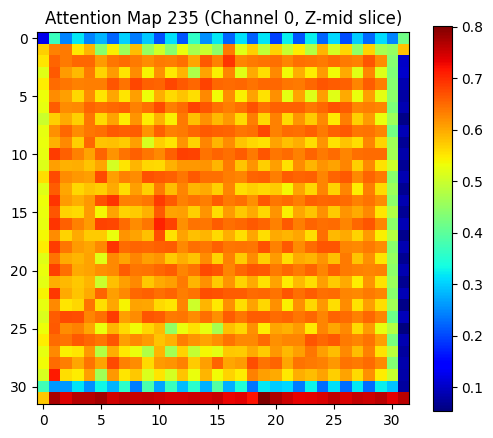

Attention map 236 shape: (1, 16, 32, 32, 32)


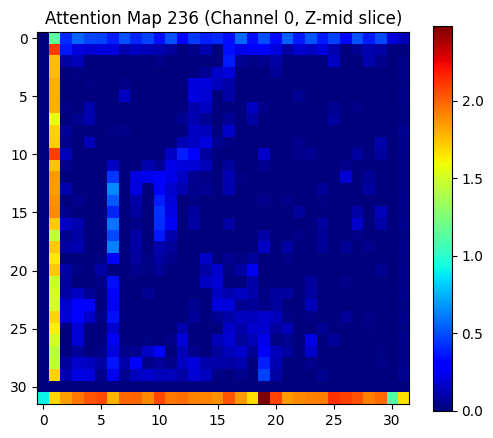

Attention map 237 shape: (1, 16, 32, 32, 32)


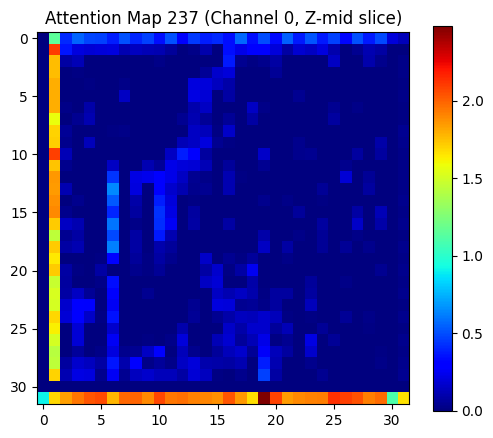

Attention map 238 shape: (1, 16, 32, 32, 32)


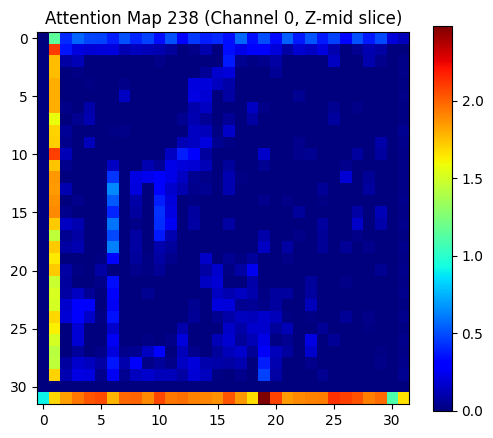

Attention map 239 shape: (1, 16, 32, 32, 32)


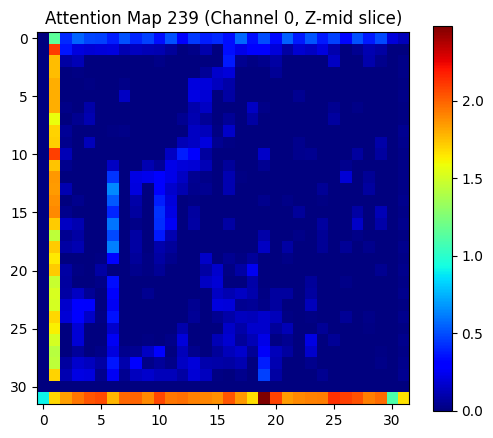

In [26]:
import matplotlib.pyplot as plt

# A list to store attention outputs
attention_maps = []

def hook_fn(module, input, output):
    """
    This function is called every time the hooked module does a forward pass.
    We'll append the attention map to our global list so we can visualize it.
    """
    # TODO: Append the module's output to the attention_maps list (convert to CPU first)
    attention_maps.append(output.cpu().detach().numpy())

# In AttentionUnet, attention is in the up_sample modules
# The attention gate outputs are part of the up_sample modules
for name, submodule in model.named_modules():
    # TODO: Identify attention modules and register a forward hook
    if 'att' in name.lower() and hasattr(submodule, 'forward'):
        print(f"Added hook to: {name}")

        # Register forward hook here
        submodule.register_forward_hook(hook_fn)

# Run a forward pass on one batch from val_loader
model.eval()
attention_maps.clear()

# TODO: Retrieve a validation sample from val_loader and move it to the correct device
val_sample = next(iter(val_loader)) # Replace with actual code
val_inputs = val_data["image"].to(device) # Move the image data to the device

print(f"val_inputs shape: {val_inputs.shape}")

with torch.no_grad():
    # TODO: Run inference on the validation inputs
    val_outputs = sliding_window_inference(
        val_inputs, roi_size=roi_size, sw_batch_size=1, predictor=model
    )

print(f"Captured {len(attention_maps)} attention maps")

# Example: Visualize the first captured attention for the first item in the batch
if attention_maps:
    for i, attn_map in enumerate(attention_maps):
        # Print shape to understand the structure
        print(f"Attention map {i} shape: {attn_map.shape}")

        # TODO: Extract and visualize a meaningful slice of the attention map
        # Hint: If 5D tensor [batch, channels, D, H, W], pick a middle Z slice
        if len(attn_map.shape) == 5:
            first_map = attn_map[0, 0, :, :, :]  # Extract first batch, first channel
            z_mid = first_map.shape[0] // 2  # Compute middle Z slice
            slice_2d = first_map[z_mid, :, :]  # Extract the 2D slice

            plt.figure(figsize=(6, 5))
            plt.title(f"Attention Map {i} (Channel 0, Z-mid slice)")
            plt.imshow(slice_2d, cmap="jet")
            plt.colorbar()
            plt.show()
        elif len(attn_map.shape) == 4:
            # TODO: Handle the case where the attention map is 4D [batch, channels, H, W]
            first_map = attn_map[0, 0, :, :]  # Extract first batch, first channel

            plt.figure(figsize=(6, 5))
            plt.title(f"Attention Map {i} (Channel 0)")
            plt.imshow(first_map, cmap="jet")
            plt.colorbar()
            plt.show()
else:
    print("No attention maps were captured. Let's try a different approach.")

    # Alternative approach: Look at the structure of the model
    print("\nModel structure:")
    for name, module in model.named_modules():
        print(f"{name}: {type(module).__name__}")

    # TODO: Try to find and register hooks for attention-related layers another way
    attention_maps.clear()

    for name, module in model.named_modules():
        if "up" in name and hasattr(module, 'forward'):
            print(f"Adding hook to up module: {name}")
            # Register forward hook here
            module.register_forward_hook(hook_fn)

    # Run inference again
    with torch.no_grad():
        # TODO: Run the model again to capture feature maps
        val_outputs = sliding_window_inference(
            val_inputs, roi_size=roi_size, sw_batch_size=1, predictor=model
        )

    print(f"Second attempt captured {len(attention_maps)} feature maps")

    # TODO: Extract and visualize the first few feature maps
    if attention_maps:
        for i, feat_map in enumerate(attention_maps[:3]):  # Show first 3 only
            print(f"Feature map {i} shape: {feat_map.shape}")

            if len(feat_map.shape) == 5:
                first_map = feat_map[0, 0, :, :, :]  # Extract first batch, first channel
                z_mid = first_map.shape[0] // 2  # Compute middle Z slice
                slice_2d = first_map[z_mid, :, :]  # Extract the 2D slice

                plt.figure(figsize=(6, 5))
                plt.title(f"Feature Map {i} (Channel 0, Z-mid slice)")
                plt.imshow(slice_2d, cmap="jet")
                plt.colorbar()
                plt.show()


### Note:
The above training loop is just 5 epochs, which is typically not enough for good performance. But it demonstrates the pipeline. Feel free to edit and test it out beyond the scope of the lab work.
And that's it! We combined a SHAP example for a tabular problem with an Attention UNet example for 3D medical imaging segmentation.